# Business Understanding

According to the UN climate report this year, some of the global warming effects are now irreversible. The effects of this are detrimental, as the sea levels continue to rise, due to the melting of ice in the arctic, areas located below the sea level are at high risk. Furthermore, as the temperature increases, this also results in extreme weather events such as hurricanes, wildfires, and drought. To mitigate global warming, some have already resorted to using clean and renewable energy sources. This can be seen as more communities are trying to replace their traditional energy sources that rely on fossil fuels, with clean energy such as solar and wind. Hence, it is crucial to estimate the future energy demand so that a more clear and realistic goal can be set for the communities. 

In this project, I will build a predictive model that estimates the future electricity consumption in New York City based on its weather data. Energy usage is correlated with the temperatures. People are more likely to use more air conditioning in hot weather and more heaters during cold periods. The project aims to help decision makers from all sectors understand the magnitude of the global warming effect and to aid in better preparation as we attempt to meet the future energy demand while adopting more clean and renewable energy. 

# Data Understanding

NYC Electricity Consumption Dataset: The dataset was found at the NYC Open Data website. The data was provided by
New York City Housing Authority (NYCHA). It contains monthly electricity consumption and cost data from 2010 January to 2021 Feburary by borough and development. It includes features such as electricity consumption, utility vendor and meter information. The electricitiy consumption data was provided in kilowatt (kW) as well as in kilowatt-hours (kWh). The difference between kWh and kW is that kW reflects the rate of electricity you use, and kWh indicates the amount of electricity you use. For this project, kWh will be taken into account. https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-April-2020-/jr24-e7cr

NYC Weather Dataset: The dataset was gathered from the National Oceanic and Atmospheric Administration (NOAA), an American scientific and regulatory agency within the United States Department of Commerce. It contains monthly mean maximum, mean minimum and mean temperatures; monthly total precipitation and snowfall; departure from normal of the mean temperature and total precipitation; monthly heating and cooling degree days; number of days that temperatures and precipitation are above or below certain thresholds; extreme daily temperature and precipitation amounts; number of days with fog; and number of days with thunderstorms. https://www.ncdc.noaa.gov/cdo-web/datasets/GSOM/locations/CITY:US360019/detail

# EDA and Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, acf, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from keras import models, layers, optimizers, regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, RepeatVector

tf.random.set_seed(3)
np.random.seed(3)

## Electricity Consumption Dataset

In [2]:
preview_e = pd.read_csv("Electric_Consumption_And_Cost__2010_-_April_2020_.csv")

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
preview_e.head()

Development Name Borough Account Name Location Meter AMR   Meter Scope  \
0            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
1            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
2            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
3            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
4            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   

   TDS #  EDP  RC Code Funding Source  ... Meter Number Estimated  \
0  118.0  248  B011800        FEDERAL  ...      7223256         N   
1  118.0  248  B011800        FEDERAL  ...      7223256         N   
2  118.0  248  B011800        FEDERAL  ...      7223256         N   
3  118.0  248  B011800        FEDERAL  ...      7223256         N   
4  118.0  248  B011800        FEDERAL  ...      7223256         N   

   Current Charges   Rate Class Bill Analyzed Consumption (KWH)  KWH Charges  \
0         15396.82  GOV/NYC/068           Yes            128800      7387.97   
1         14556.34  GOV/NYC/068           Yes            115200      6607.87   
2         13904.98  GOV/NYC/068           Yes            103200      5919.55   
3         14764.04  GOV/NYC/068           Yes            105600      6057.22   
4         13729.54  GOV/NYC/068           Yes             97600      5598.34   

  Consumption (KW) KW Charges  Other charges  
0            216.0     2808.0        5200.85  
1            224.0     2912.0        5036.47  
2            216.0     2808.0        5177.43  
3            208.0     2704.0        6002.82  
4            216.0     2808.0        5323.20  

[5 rows x 27 columns]

In [4]:
preview_e[0:4].T

0                         1  \
Development Name                       ADAMS                     ADAMS   
Borough                                BRONX                     BRONX   
Account Name                           ADAMS                     ADAMS   
Location                              BLD 05                    BLD 05   
Meter AMR                               NONE                      NONE   
Meter Scope                     BLD 01 to 07              BLD 01 to 07   
TDS #                                    118                       118   
EDP                                      248                       248   
RC Code                              B011800                   B011800   
Funding Source                       FEDERAL                   FEDERAL   
AMP #                           NY005001180P              NY005001180P   
Vendor Name         NEW YORK POWER AUTHORITY  NEW YORK POWER AUTHORITY   
UMIS BILL ID                         1842037                   1844205   
Revenue Month                        2010-01                   2010-02   
Service Start Date                12/24/2009                01/26/2010   
Service End Date                  01/26/2010                02/25/2010   
# days                                    33                        30   
Meter Number                         7223256                   7223256   
Estimated                                  N                         N   
Current Charges                      15396.8                   14556.3   
Rate Class                       GOV/NYC/068               GOV/NYC/068   
Bill Analyzed                            Yes                       Yes   
Consumption (KWH)                     128800                    115200   
KWH Charges                          7387.97                   6607.87   
Consumption (KW)                         216                       224   
KW Charges                              2808                      2912   
Other charges                        5200.85                   5036.47   

                                           2                         3  
Development Name                       ADAMS                     ADAMS  
Borough                                BRONX                     BRONX  
Account Name                           ADAMS                     ADAMS  
Location                              BLD 05                    BLD 05  
Meter AMR                               NONE                      NONE  
Meter Scope                     BLD 01 to 07              BLD 01 to 07  
TDS #                                    118                       118  
EDP                                      248                       248  
RC Code                              B011800                   B011800  
Funding Source                       FEDERAL                   FEDERAL  
AMP #                           NY005001180P              NY005001180P  
Vendor Name         NEW YORK POWER AUTHORITY  NEW YORK POWER AUTHORITY  
UMIS BILL ID                         1841378                   1847148  
Revenue Month                        2010-03                   2010-04  
Service Start Date                02/25/2010                03/26/2010  
Service End Date                  03/26/2010                04/26/2010  
# days                                    29                        31  
Meter Number                         7223256                   7223256  
Estimated                                  N                         N  
Current Charges                        13905                     14764  
Rate Class                       GOV/NYC/068               GOV/NYC/068  
Bill Analyzed                            Yes                       Yes  
Consumption (KWH)                     103200                    105600  
KWH Charges                          5919.55                   6057.22  
Consumption (KW)                         216                       208  
KW Charges                              2808                      2704  

>The first 4 rows are the data from the same location. It looks like the dataset is organized by location and sorted by month. 

In [5]:
preview_e.describe()

TDS #            EDP  UMIS BILL ID         # days  \
count  360690.000000  362630.000000  3.626300e+05  362622.000000   
mean      117.804164     424.808728  5.259728e+06      30.420565   
std       128.750224     186.296821  2.508627e+06       1.738034   
min         1.000000      63.000000  1.726303e+06       1.000000   
25%        33.000000     225.000000  3.037077e+06      29.000000   
50%        64.000000     426.000000  4.759979e+06      30.000000   
75%       155.000000     552.000000  7.794804e+06      32.000000   
max       582.000000     999.000000  9.860630e+06     257.000000   

       Current Charges  Consumption (KWH)    KWH Charges  Consumption (KW)  \
count    362630.000000       3.626300e+05  362630.000000     362630.000000   
mean       4213.435430       3.181071e+04    1493.563547         64.579469   
std        6055.361739       4.976442e+04    2518.766222        620.513443   
min       -1207.550000       0.000000e+00       0.000000          0.000000   
25%         530.330000       0.000000e+00       0.000000          0.000000   
50%        2348.580000       1.472000e+04     638.110000         25.490000   
75%        5598.632500       4.696000e+04    2126.127500         92.160000   
max      329800.370000       1.779600e+06  195575.860000     329074.000000   

          KW Charges  Other charges  
count  362630.000000  362630.000000  
mean      956.648705    1763.223178  
std      1637.013845    3580.983245  
min         0.000000  -59396.430000  
25%         0.000000       7.792500  
50%       322.400000     949.450000  
75%      1400.500000    2710.912500  
max     78782.960000  134224.510000

In [6]:
preview_e.columns

Index(['Development Name', 'Borough', 'Account Name', 'Location', 'Meter AMR',
       'Meter Scope', 'TDS #', 'EDP', 'RC Code', 'Funding Source', 'AMP #',
       'Vendor Name', 'UMIS BILL ID', 'Revenue Month', 'Service Start Date',
       'Service End Date', '# days', 'Meter Number', 'Estimated',
       'Current Charges', 'Rate Class', 'Bill Analyzed', 'Consumption (KWH)',
       'KWH Charges', 'Consumption (KW)', 'KW Charges', 'Other charges'],
      dtype='object')

In [7]:
preview_e['Borough'].unique()

array(['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND',
       'NON DEVELOPMENT FACILITY', 'FHA'], dtype=object)

In [8]:
preview_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362630 entries, 0 to 362629
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    361947 non-null  object 
 1   Borough             362630 non-null  object 
 2   Account Name        362630 non-null  object 
 3   Location            353112 non-null  object 
 4   Meter AMR           362476 non-null  object 
 5   Meter Scope         19106 non-null   object 
 6   TDS #               360690 non-null  float64
 7   EDP                 362630 non-null  int64  
 8   RC Code             362630 non-null  object 
 9   Funding Source      362630 non-null  object 
 10  AMP #               360744 non-null  object 
 11  Vendor Name         362630 non-null  object 
 12  UMIS BILL ID        362630 non-null  int64  
 13  Revenue Month       362630 non-null  object 
 14  Service Start Date  362622 non-null  object 
 15  Service End Date    362622 non-nul

In [9]:
preview_e.loc[:, ['Service Start Date', 'Service End Date']]

Service Start Date Service End Date
0              12/24/2009       01/26/2010
1              01/26/2010       02/25/2010
2              02/25/2010       03/26/2010
3              03/26/2010       04/26/2010
4              04/26/2010       05/24/2010
...                   ...              ...
362625         01/26/2021       02/25/2021
362626         01/26/2021       02/25/2021
362627         01/26/2021       02/25/2021
362628         01/26/2021       02/25/2021
362629         01/26/2021       02/25/2021

[362630 rows x 2 columns]

In [10]:
preview_e.isna().sum()

Development Name         683
Borough                    0
Account Name               0
Location                9518
Meter AMR                154
Meter Scope           343524
TDS #                   1940
EDP                        0
RC Code                    0
Funding Source             0
AMP #                   1886
Vendor Name                0
UMIS BILL ID               0
Revenue Month              0
Service Start Date         8
Service End Date           8
# days                     8
Meter Number               0
Estimated                341
Current Charges            0
Rate Class                 0
Bill Analyzed              0
Consumption (KWH)          0
KWH Charges                0
Consumption (KW)           0
KW Charges                 0
Other charges              0
dtype: int64

In [11]:
missing = preview_e.loc[preview_e['Service End Date'].isna()]
missing

Development Name    Borough        Account Name          Location  \
294047  LOWER EAST SIDE II  MANHATTAN  LOWER EAST SIDE II            BLD 03   
296910       RED HOOK EAST   BROOKLYN       RED HOOK EAST  BLD 29 - STORE 4   
296913       RED HOOK EAST   BROOKLYN       RED HOOK EAST  BLD 29 - STORE 5   
337296  LOWER EAST SIDE II  MANHATTAN  LOWER EAST SIDE II            BLD 03   
337297  LOWER EAST SIDE II  MANHATTAN  LOWER EAST SIDE II            BLD 03   
337298  LOWER EAST SIDE II  MANHATTAN  LOWER EAST SIDE II            BLD 03   
347294       RED HOOK EAST   BROOKLYN       RED HOOK EAST  BLD 29 - STORE 4   
347298       RED HOOK EAST   BROOKLYN       RED HOOK EAST  BLD 29 - STORE 5   

       Meter AMR                  Meter Scope  TDS #  EDP  RC Code  \
294047      NONE  APT 01A - Management Office  337.0  783  M033700   
296910      NONE                          NaN    4.0  202  K000400   
296913      NONE                          NaN    4.0  202  K000400   
337296      NONE  APT 01A - Management Office  337.0  783  M033700   
337297      NONE  APT 01A - Management Office  337.0  783  M033700   
337298      NONE  APT 01A - Management Office  337.0  783  M033700   
347294      NONE                          NaN    4.0  202  K000400   
347298      NONE                          NaN    4.0  202  K000400   

       Funding Source  ... Meter Number Estimated  Current Charges  \
294047        FEDERAL  ...      5503302       NaN             0.00   
296910        FEDERAL  ...    009956008         N            15.96   
296913        FEDERAL  ...    009956007         N            20.22   
337296        FEDERAL  ...      5503302       NaN             0.00   
337297        FEDERAL  ...      5503302         N             0.04   
337298        FEDERAL  ...      5503302         N             0.00   
347294        FEDERAL  ...    009956008         N            15.96   
347298        FEDERAL  ...    009956007         N            20.22   

         Rate Class Bill Analyzed Consumption (KWH)  KWH Charges  \
294047  GOV/NYC/062           Yes                 0          0.0   
296910          EL2           Yes                 0          0.0   
296913          EL2           Yes                 0          0.0   
337296  GOV/NYC/062           Yes                 0          0.0   
337297  GOV/NYC/062           Yes                 0          0.0   
337298  GOV/NYC/062           Yes                 0          0.0   
347294          EL2           Yes                 0          0.0   
347298          EL2           Yes                 0          0.0   

       Consumption (KW) KW Charges  Other charges  
294047              0.0        0.0           0.00  
296910              0.0        0.0          15.96  
296913              0.0        0.0          20.22  
337296              0.0        0.0           0.00  
337297              0.0        0.0           0.04  
337298              0.0        0.0           0.00  
347294              0.0        0.0          15.96  
347298              0.0        0.0          20.22  

[8 rows x 27 columns]

In [12]:
len(missing.index)

8

In [13]:
# dropping rows with missing date
preview_e = preview_e.drop(missing.index, axis=0)

In [14]:
preview_e.isna().sum()

Development Name         683
Borough                    0
Account Name               0
Location                9518
Meter AMR                154
Meter Scope           343520
TDS #                   1940
EDP                        0
RC Code                    0
Funding Source             0
AMP #                   1886
Vendor Name                0
UMIS BILL ID               0
Revenue Month              0
Service Start Date         0
Service End Date           0
# days                     0
Meter Number               0
Estimated                339
Current Charges            0
Rate Class                 0
Bill Analyzed              0
Consumption (KWH)          0
KWH Charges                0
Consumption (KW)           0
KW Charges                 0
Other charges              0
dtype: int64

In [15]:
preview_e['DATE'] = pd.to_datetime(preview_e['Service End Date'], format="%m/%d/%Y")

In [16]:
# checking time range of the dataset
preview_e['DATE'].min(), preview_e['DATE'].max()

(Timestamp('2010-01-20 00:00:00'), Timestamp('2021-02-25 00:00:00'))

In [17]:
preview_e.set_index('DATE', inplace=True)

In [18]:
# seperating boroughs
Manhattan = preview_e.loc[preview_e['Borough'] == 'MANHATTAN']
Bronx = preview_e.loc[preview_e['Borough'] == 'BRONX']
Brooklyn = preview_e.loc[preview_e['Borough'] == 'BROOKLYN']
Queens = preview_e.loc[preview_e['Borough'] == 'QUEENS']
Staten = preview_e.loc[preview_e['Borough'] == 'STATEN ISLAND']

In [19]:
Manhattan['Location'].unique()

array(['BLD 01', 'BLD 06', 'BLD 04', 'BLD 09', 'BLD 12', 'BLD 02',
       'BLD 10', 'BLD 13', 'BLD 08', 'BLD 11', 'BLD 03', 'BLD 05', nan,
       'BLD 18', 'BLD 28', 'DOUGLASS I BLD 11', 'DOUGLASS I BLD 01',
       'DOUGLASS I BLD 08', 'DOUGLASS I BLD 09', 'DOUGLASS I BLD 16',
       'DOUGLASS I BLD 05', 'DOUGLASS I BLD 06', 'DOUGLASS I BLD 04',
       'DOUGLASS I BLD 07', 'DOUGLASS I BLD 17', 'DOUGLASS I BLD 12',
       'DOUGLASS II BLD 13', 'DOUGLASS II BLD 14', 'DOUGLASS II BLD 01',
       'DOUGLASS II BLD 15', 'DOUGLASS II BLD 02', 'DOUGLASS II BLD 03',
       'BLD 05 - Community Center', 'BLD 07', 'BLD 03 - Community Center',
       'BLD 02 - Community Center', 'BLD 14', 'BLD 10 - Community Center',
       'JEFFERSON BLD 01', 'JEFFERSON BLD 03', 'JEFFERSON BLD 10',
       'JEFFERSON BLD 07', 'JEFFERSON BLD 06', 'JEFFERSON BLD 16',
       'JEFFERSON BLD 13', 'JEFFERSON BLD 04', 'JEFFERSON BLD 18',
       'JEFFERSON BLD 08', 'JEFFERSON BLD 09', 'JEFFERSON BLD 12',
       'JEFFERSON 

>It looks like 'Location' indicates a building.

In [20]:
print('The dataset has data from', Manhattan['Location'].nunique(), 'buildings in Manhattan.')
print('The dataset has data from', Bronx['Location'].nunique(), 'buildings in the Bronx.')
print('The dataset has data from', Brooklyn['Location'].nunique(), 'buildings in Brooklyn.')
print('The dataset has data from', Queens['Location'].nunique(), 'buildings in Queens.')
print('The dataset has data from', Staten['Location'].nunique(), 'buildings in Staten Island.')

The dataset has data from 195 buildings in Manhattan.
The dataset has data from 69 buildings in the Bronx.
The dataset has data from 262 buildings in Brooklyn.
The dataset has data from 93 buildings in Queens.
The dataset has data from 10 buildings in Staten Island.


In [21]:
print('The dataset has', len(Manhattan), 'Manhattan data.')
print('The dataset has', len(Bronx), 'Bronx data.')
print('The dataset has', len(Brooklyn), 'Brooklyn data.')
print('The dataset has', len(Queens), 'Queens data.')
print('The dataset has', len(Staten), 'Staten data.')

The dataset has 93078 Manhattan data.
The dataset has 82782 Bronx data.
The dataset has 138234 Brooklyn data.
The dataset has 42449 Queens data.
The dataset has 2776 Staten data.


>This is obviously not all the data in New York City as the number of buildings in the dataset is small. When resampling time series datasets, summing the consumption data for each month would be misleading due to the insufficient data. It makes more sense to use mean value for each month. For this project, I will group data by borough and resample by monthly mean value. This means that the resampled figure will represent average building electricity consumption in each borough. 

In [22]:
# creating monthly time series dataset
electric_manhattan = Manhattan.resample('MS').mean()
electric_bronx = Bronx.resample('MS').mean()
electric_brooklyn = Brooklyn.resample('MS').mean()
electric_queens = Queens.resample('MS').mean()
electric_staten = Staten.resample('MS').mean()
electric_manhattan

TDS #         EDP  UMIS BILL ID     # days  Current Charges  \
DATE                                                                           
2010-01-01  153.062400  422.840000  1.864067e+06  32.977600      5920.373584   
2010-02-01  150.317536  418.633491  1.851625e+06  29.996840      5209.318088   
2010-03-01  151.031496  419.362205  1.853456e+06  29.020472      5227.610898   
2010-04-01  150.461417  418.916535  1.857155e+06  30.973228      5627.110929   
2010-05-01  150.461417  418.916535  1.858569e+06  28.007874      5894.134315   
...                ...         ...           ...        ...              ...   
2020-10-01  111.793779  391.523041  9.571972e+06  29.995392      3647.525841   
2020-11-01  111.853518  391.726644  9.637802e+06  29.000000      2878.707243   
2020-12-01  111.853518  391.726644  9.717936e+06  33.000000      3581.841995   
2021-01-01  111.853518  391.726644  9.776799e+06  34.000000      3752.018535   
2021-02-01  111.793779  391.523041  9.853387e+06  30.000000      4039.617419   

            Consumption (KWH)  KWH Charges  Consumption (KW)   KW Charges  \
DATE                                                                        
2010-01-01       49050.579200  2856.579760         81.289776  1030.621216   
2010-02-01       42389.737757  2473.058863         77.466367   982.311169   
2010-03-01       40492.149606  2359.905874         78.058252   992.384488   
2010-04-01       40533.979528  2356.151827         79.519465  1006.433906   
2010-05-01       41163.179528  2391.845386         93.629291  1185.370724   
...                       ...          ...               ...          ...   
2020-10-01       29538.725806   982.571118         62.327880   647.545599   
2020-11-01       28885.369089   963.757047         54.483183   567.380473   
2020-12-01       32497.295271  1097.292849         56.265029   590.974556   
2021-01-01       32455.273356  1208.553495         52.777070   629.065167   
2021-02-01       28880.169355  1077.307558         51.779781   622.234124   

            Other charges  
DATE                       
2010-01-01    2033.172608  
2010-02-01    1753.948057  
2010-03-01    1875.320535  
2010-04-01    2264.525197  
2010-05-01    2316.918205  
...                   ...  
2020-10-01    2017.409124  
2020-11-01    1347.569723  
2020-12-01    1893.574591  
2021-01-01    1914.399873  
2021-02-01    2340.075737  

[134 rows x 10 columns]

In [23]:
# extracting consumption data
electric_manhattan = pd.DataFrame(electric_manhattan['Consumption (KWH)'])
electric_bronx = pd.DataFrame(electric_bronx['Consumption (KWH)'])
electric_brooklyn = pd.DataFrame(electric_brooklyn['Consumption (KWH)'])
electric_queens = pd.DataFrame(electric_queens['Consumption (KWH)'])
electric_staten = pd.DataFrame(electric_staten['Consumption (KWH)'])
electric_manhattan

Consumption (KWH)
DATE                         
2010-01-01       49050.579200
2010-02-01       42389.737757
2010-03-01       40492.149606
2010-04-01       40533.979528
2010-05-01       41163.179528
...                       ...
2020-10-01       29538.725806
2020-11-01       28885.369089
2020-12-01       32497.295271
2021-01-01       32455.273356
2021-02-01       28880.169355

[134 rows x 1 columns]

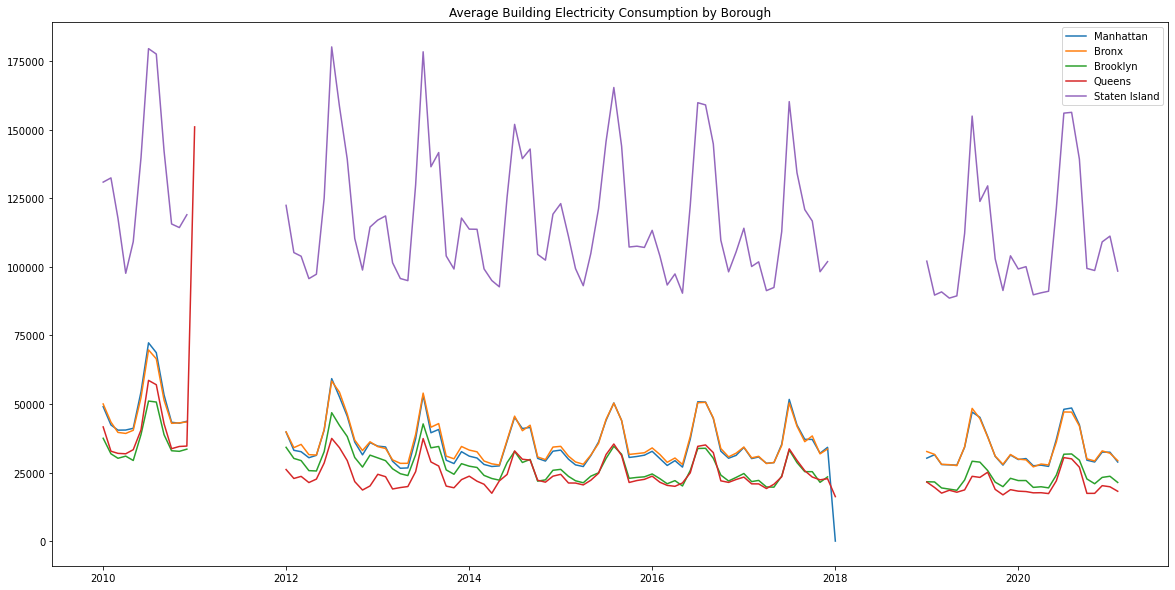

In [24]:
# plotting monthly consumption by borough
fig=plt.figure(figsize=(20,10))

plt.plot(electric_manhattan, label = "Manhattan")
plt.plot(electric_bronx, label = "Bronx")
plt.plot(electric_brooklyn, label = "Brooklyn")
plt.plot(electric_queens, label = "Queens")
plt.plot(electric_staten, label = "Staten Island")

plt.title("Average Building Electricity Consumption by Borough")
plt.legend()
plt.show()

>Staten Island's average building electricity consumption appears much higher than the rest of New York City. As the dataset includes only 10 buildings in Staten Islands, this issue requires further investigation. The dataset also includes rather small number of buildings in Queens and the Bronx. Thus, I will focus on Manhattan as a sample for this project. Next, I will investigate missing data in the dataset.

In [25]:
electric_manhattan.isna().sum()

Consumption (KWH)    23
dtype: int64

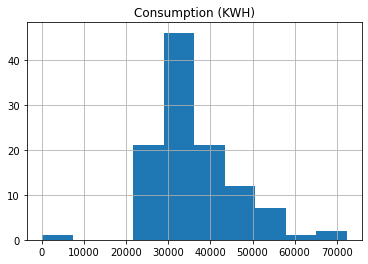

In [26]:
electric_manhattan.hist();

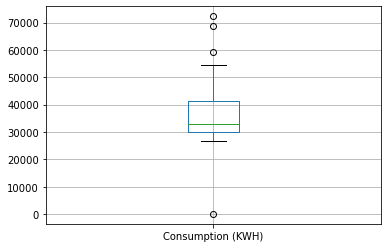

In [27]:
electric_manhattan.boxplot();

In [28]:
electric_manhattan.value_counts()

Consumption (KWH)
72308.113565         1
30943.024306         1
30112.739477         1
30136.212548         1
30141.564162         1
                    ..
40492.149606         1
40533.979528         1
40537.145912         1
40742.364246         1
72.000000            1
Length: 111, dtype: int64

In [29]:
electric_manhattan.loc[electric_manhattan['Consumption (KWH)'] <= 100]

Consumption (KWH)
DATE                         
2018-01-01               72.0

In [30]:
electric_manhattan.loc['2017-12-01'], electric_manhattan.loc['2018-01-01']

(Consumption (KWH)    34233.87194
 Name: 2017-12-01 00:00:00, dtype: float64,
 Consumption (KWH)    72.0
 Name: 2018-01-01 00:00:00, dtype: float64)

>There is no data in 2011. In 2018, there is only January consumption data but even that has a very low value (72.0). I suspect the completeness of this month's data. In order to obatin the missing data, I have reached out to New York City Housing Authority who provides the data. Until I hear from them, I will make 4 datasets: 2 versions of train set, 1 validation set and 1 test set. The first version of the train set will be the seamless data from 2012 to 2017 (6 years). Within this seamless data, I will use first 5 years as the second version of the train set and the next 1 year as a validation set. I will also keep data from 2019 as a test set. The reason I seperate the dataset in this way is to compare the results and see if seamlessness and more training data have any effect on model performance. 

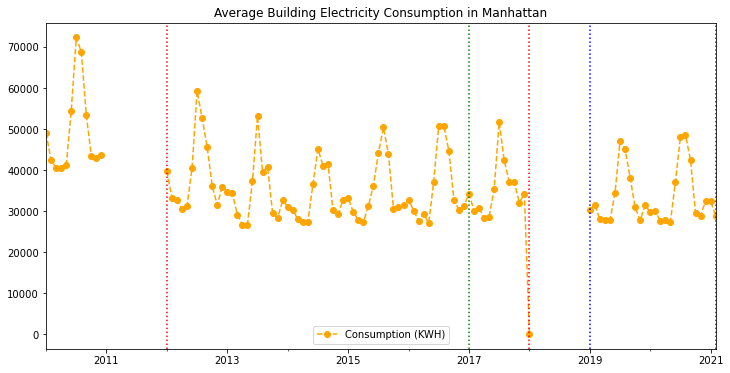

In [31]:
ax = electric_manhattan.plot(linestyle='--', marker='o', color='orange', figsize=(12,6), xlabel="")
plt.title("Average Building Electricity Consumption in Manhattan")
ax.axvline(electric_manhattan.index[12*2], linestyle=":", color='red')
ax.axvline(electric_manhattan.index[12*7], linestyle=":", color='green')
ax.axvline(electric_manhattan.index[12*8], linestyle=":", color='red')
ax.axvline(electric_manhattan.index[12*9], linestyle=":", color='blue')
ax.axvline(electric_manhattan.index[-1], linestyle=":", color='blue');

## Weather Dataset

In [32]:
preview_w = pd.read_csv('nyc_weather.csv')

In [33]:
preview_w.head()

STATION                         NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
1  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
2  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
3  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
4  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   

      DATE  AWND AWND_ATTRIBUTES  CDSD CDSD_ATTRIBUTES  ...  TSUN  \
0  2010-01   3.4             3,W   0.0               0  ...   NaN   
1  2010-02   3.6              ,W   0.0               0  ...   NaN   
2  2010-03   3.6              ,W   0.0               0  ...   NaN   
3  2010-04   2.8              ,W  11.9               0  ...   NaN   
4  2010-05   2.5              ,W  73.6               0  ...   NaN   

  TSUN_ATTRIBUTES   WDF2 WDF2_ATTRIBUTES   WDF5 WDF5_ATTRIBUTES  WSF2  \
0             NaN  290.0              ,X  290.0             1,X  11.6   
1             NaN   60.0              ,X   60.0              ,X  13.0   
2             NaN   60.0              ,X   60.0              ,X  16.5   
3             NaN  270.0              ,X  300.0              ,X   9.4   
4             NaN  270.0              ,X  280.0              ,X  11.2   

  WSF2_ATTRIBUTES  WSF5 WSF5_ATTRIBUTES  
0              ,X  17.4             1,X  
1              ,X  17.9              ,X  
2              ,X  23.7              ,X  
3              ,X  16.1              ,X  
4              ,X  17.9              ,X  

[5 rows x 64 columns]

In [34]:
preview_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 64 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          514 non-null    object 
 1   NAME             514 non-null    object 
 2   LATITUDE         514 non-null    float64
 3   LONGITUDE        514 non-null    float64
 4   ELEVATION        514 non-null    float64
 5   DATE             514 non-null    object 
 6   AWND             405 non-null    float64
 7   AWND_ATTRIBUTES  405 non-null    object 
 8   CDSD             417 non-null    float64
 9   CDSD_ATTRIBUTES  396 non-null    object 
 10  CLDD             417 non-null    float64
 11  CLDD_ATTRIBUTES  417 non-null    object 
 12  DP01             511 non-null    float64
 13  DP01_ATTRIBUTES  511 non-null    object 
 14  DP10             511 non-null    float64
 15  DP10_ATTRIBUTES  511 non-null    object 
 16  DSND             417 non-null    float64
 17  DSND_ATTRIBUTES 

In [35]:
preview_w['DATE'].value_counts()

2015-04    4
2015-03    4
2020-02    4
2014-02    4
2019-03    4
          ..
2016-08    3
2010-09    3
2011-03    3
2010-06    3
2011-06    3
Name: DATE, Length: 140, dtype: int64

In [36]:
preview_w['DATE'] = pd.to_datetime(preview_w['DATE'], format="%Y/%m")
preview_w.head()

STATION                         NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
1  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
2  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
3  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
4  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   

        DATE  AWND AWND_ATTRIBUTES  CDSD CDSD_ATTRIBUTES  ...  TSUN  \
0 2010-01-01   3.4             3,W   0.0               0  ...   NaN   
1 2010-02-01   3.6              ,W   0.0               0  ...   NaN   
2 2010-03-01   3.6              ,W   0.0               0  ...   NaN   
3 2010-04-01   2.8              ,W  11.9               0  ...   NaN   
4 2010-05-01   2.5              ,W  73.6               0  ...   NaN   

  TSUN_ATTRIBUTES   WDF2 WDF2_ATTRIBUTES   WDF5 WDF5_ATTRIBUTES  WSF2  \
0             NaN  290.0              ,X  290.0             1,X  11.6   
1             NaN   60.0              ,X   60.0              ,X  13.0   
2             NaN   60.0              ,X   60.0              ,X  16.5   
3             NaN  270.0              ,X  300.0              ,X   9.4   
4             NaN  270.0              ,X  280.0              ,X  11.2   

  WSF2_ATTRIBUTES  WSF5 WSF5_ATTRIBUTES  
0              ,X  17.4             1,X  
1              ,X  17.9              ,X  
2              ,X  23.7              ,X  
3              ,X  16.1              ,X  
4              ,X  17.9              ,X  

[5 rows x 64 columns]

In [37]:
preview_w['DATE'].min(), preview_w['DATE'].max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2021-08-01 00:00:00'))

In [38]:
preview_w.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND',
       'AWND_ATTRIBUTES', 'CDSD', 'CDSD_ATTRIBUTES', 'CLDD', 'CLDD_ATTRIBUTES',
       'DP01', 'DP01_ATTRIBUTES', 'DP10', 'DP10_ATTRIBUTES', 'DSND',
       'DSND_ATTRIBUTES', 'DSNW', 'DSNW_ATTRIBUTES', 'DT00', 'DT00_ATTRIBUTES',
       'DT32', 'DT32_ATTRIBUTES', 'DX32', 'DX32_ATTRIBUTES', 'DX70',
       'DX70_ATTRIBUTES', 'DX90', 'DX90_ATTRIBUTES', 'EMNT', 'EMNT_ATTRIBUTES',
       'EMSD', 'EMSD_ATTRIBUTES', 'EMSN', 'EMSN_ATTRIBUTES', 'EMXP',
       'EMXP_ATTRIBUTES', 'EMXT', 'EMXT_ATTRIBUTES', 'HDSD', 'HDSD_ATTRIBUTES',
       'HTDD', 'HTDD_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW',
       'SNOW_ATTRIBUTES', 'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES',
       'TMIN', 'TMIN_ATTRIBUTES', 'TSUN', 'TSUN_ATTRIBUTES', 'WDF2',
       'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'WSF2', 'WSF2_ATTRIBUTES',
       'WSF5', 'WSF5_ATTRIBUTES'],
      dtype='object')

In [39]:
'''
I will use air temperature data from the dataset:
CDSD	Cooling Degree Days Season 
EMNT	Extreme minimum temperature 
EMXT	Extreme maximum temperature 
HDSD	Heating Degree Days Season 
TAVG	Average temperature
TMAX	Maximum temperature
TMIN	Minimum temperature
'''

'\nI will use air temperature data from the dataset:\nCDSD\tCooling Degree Days Season \nEMNT\tExtreme minimum temperature \nEMXT\tExtreme maximum temperature \nHDSD\tHeating Degree Days Season \nTAVG\tAverage temperature\nTMAX\tMaximum temperature\nTMIN\tMinimum temperature\n'

In [40]:
preview_w['NAME'].unique()

array(['NY CITY CENTRAL PARK, NY US', 'LAGUARDIA AIRPORT, NY US',
       'MIDDLE VILLAGE 0.5 SW, NY US', 'JFK INTERNATIONAL AIRPORT, NY US'],
      dtype=object)

In [41]:
# extracting temperature data
keep = ['DATE', 'NAME', 'CDSD', 'EMNT', 'EMXT', 'HDSD', 'TAVG', 'TMAX', 'TMIN']
preview_w = preview_w[keep]

In [42]:
# renaming columns
preview_w = preview_w.rename(columns={'CDSD': 'Cooling Degree Days Season',
                                      'EMNT': 'Extreme Minimum Temperature',
                                      'EMXT': 'Extreme Maximum Temperature',
                                      'HDSD': 'Heating Degree Days Season',
                                      'TAVG': 'Average Temperature',
                                      'TMAX': 'Maximum Temperature',
                                      'TMIN': 'Minimum Temperature'})

In [43]:
preview_w.set_index('DATE', inplace=True)
preview_w

NAME  Cooling Degree Days Season  \
DATE                                                                       
2010-01-01       NY CITY CENTRAL PARK, NY US                         0.0   
2010-02-01       NY CITY CENTRAL PARK, NY US                         0.0   
2010-03-01       NY CITY CENTRAL PARK, NY US                         0.0   
2010-04-01       NY CITY CENTRAL PARK, NY US                        11.9   
2010-05-01       NY CITY CENTRAL PARK, NY US                        73.6   
...                                      ...                         ...   
2021-04-01  JFK INTERNATIONAL AIRPORT, NY US                         0.0   
2021-05-01  JFK INTERNATIONAL AIRPORT, NY US                        26.9   
2021-06-01  JFK INTERNATIONAL AIRPORT, NY US                       136.1   
2021-07-01  JFK INTERNATIONAL AIRPORT, NY US                       322.7   
2021-08-01  JFK INTERNATIONAL AIRPORT, NY US                         NaN   

            Extreme Minimum Temperature  Extreme Maximum Temperature  \
DATE                                                                   
2010-01-01                        -10.6                         13.9   
2010-02-01                         -8.3                          7.8   
2010-03-01                         -1.7                         23.3   
2010-04-01                          4.4                         33.3   
2010-05-01                          5.0                         33.3   
...                                 ...                          ...   
2021-04-01                         -1.6                         22.8   
2021-05-01                          5.6                         34.4   
2021-06-01                         11.1                         32.8   
2021-07-01                         15.0                         32.2   
2021-08-01                          NaN                          NaN   

            Heating Degree Days Season  Average Temperature  \
DATE                                                          
2010-01-01                      1487.8                  0.3   
2010-02-01                      1983.7                  0.6   
2010-03-01                      2273.1                  9.0   
2010-04-01                      2404.0                 14.4   
2010-05-01                      2461.0                 18.5   
...                                ...                  ...   
2021-04-01                      2425.1                 11.1   
2021-05-01                      2516.6                 16.3   
2021-06-01                      2518.9                 21.9   
2021-07-01                         0.8                 24.3   
2021-08-01                         NaN                  NaN   

            Maximum Temperature  Minimum Temperature  
DATE                                                  
2010-01-01                  3.4                 -2.8  
2010-02-01                  3.3                 -2.0  
2010-03-01                 12.8                  5.2  
2010-04-01                 19.6                  9.1  
2010-05-01                 23.6                 13.4  
...                         ...                  ...  
2021-04-01                 15.9                  6.3  
2021-05-01                 21.3                 11.2  
2021-06-01                 26.6                 17.2  
2021-07-01                 28.3                 20.3  
2021-08-01                  NaN                  NaN  

[514 rows x 8 columns]

In [44]:
# seperating locations
central_park = preview_w.loc[preview_w['NAME'] == 'NY CITY CENTRAL PARK, NY US']    #Manhattan
laguardia = preview_w.loc[preview_w['NAME'] == 'LAGUARDIA AIRPORT, NY US']          #Queens
middle_village = preview_w.loc[preview_w['NAME'] == 'MIDDLE VILLAGE 0.5 SW, NY US'] #Brooklyn
jfk = preview_w.loc[preview_w['NAME'] == 'JFK INTERNATIONAL AIRPORT, NY US']        

In [45]:
# creating monthly time series dataset
weather_central_park = central_park.resample('MS').mean()

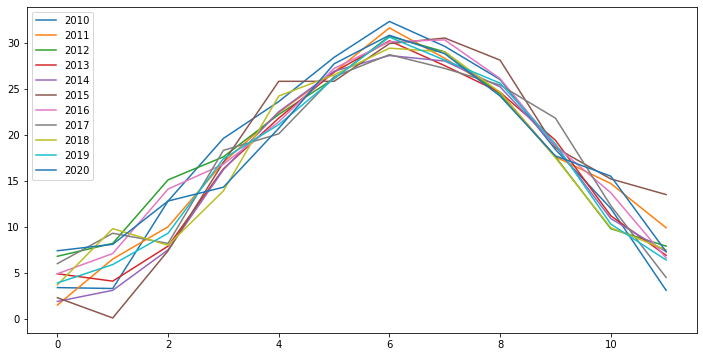

In [46]:
# plotting all years for 'Maximum Temperature'
year_groups = weather_central_park['Maximum Temperature'].loc[:'2020-12-01']
year_groups = year_groups.groupby(pd.Grouper(freq ='A'))
temp_annual = pd.DataFrame() 

for yr, group in year_groups:
    temp_annual[yr.year]=group.values.ravel()

temp_annual.plot(figsize=(12,6), subplots=False, legend=True)
plt.legend(loc='upper left')
plt.show()

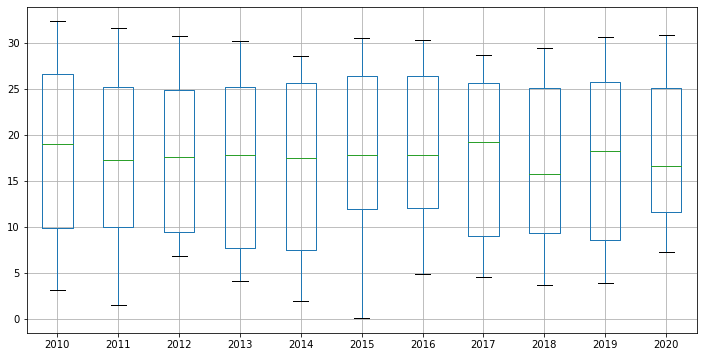

In [47]:
# plotting box plot for 'Maximum Temperature'
temp_annual.boxplot(figsize=(12,6))
plt.show()

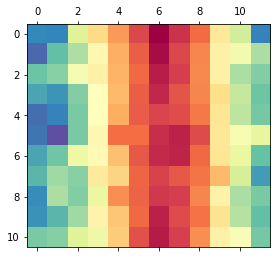

In [48]:
# plotting heatmap for 'Maximum Temperature'
year_matrix = temp_annual.T

plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.show()

In [49]:
# counting time range in the electricity consumption dataset
(12 *11) + 2

134

>In order to merge two datasets, the index in both datasets have to be matched. The electricity consumtion dataset range from January 2010 to Feburary 2021. Thus, I will select the same range in the weather dataset. Also, the central park temperature data will be used as I selected Manhattan for the sample. 

In [50]:
weather_central_park = weather_central_park.loc[:'2021-02-01']
weather_central_park

Cooling Degree Days Season  Extreme Minimum Temperature  \
DATE                                                                  
2010-01-01                         0.0                        -10.6   
2010-02-01                         0.0                         -8.3   
2010-03-01                         0.0                         -1.7   
2010-04-01                        11.9                          4.4   
2010-05-01                        73.6                          5.0   
...                                ...                          ...   
2020-10-01                       722.3                          0.0   
2020-11-01                       725.4                         -1.0   
2020-12-01                       725.4                         -6.6   
2021-01-01                         0.0                         -9.9   
2021-02-01                         0.0                         -8.2   

            Extreme Maximum Temperature  Heating Degree Days Season  \
DATE                                                                  
2010-01-01                         13.9                      1487.8   
2010-02-01                          7.8                      1983.7   
2010-03-01                         23.3                      2273.1   
2010-04-01                         33.3                      2404.0   
2010-05-01                         33.3                      2461.0   
...                                 ...                         ...   
2020-10-01                         23.3                       146.8   
2020-11-01                         23.9                       350.6   
2020-12-01                         16.7                       794.1   
2021-01-01                         10.6                      1314.0   
2021-02-01                         12.2                      1792.6   

            Average Temperature  Maximum Temperature  Minimum Temperature  
DATE                                                                       
2010-01-01                  0.3                  3.4                 -2.8  
2010-02-01                  0.6                  3.3                 -2.0  
2010-03-01                  9.0                 12.8                  5.2  
2010-04-01                 14.4                 19.6                  9.1  
2010-05-01                 18.5                 23.6                 13.4  
...                         ...                  ...                  ...  
2020-10-01                 14.4                 17.7                 11.0  
2020-11-01                 11.6                 15.5                  7.8  
2020-12-01                  4.0                  7.3                  0.8  
2021-01-01                  1.6                  4.3                 -1.1  
2021-02-01                  1.2                  3.9                 -1.4  

[134 rows x 7 columns]

In [51]:
weather_central_park.isna().sum()

Cooling Degree Days Season     0
Extreme Minimum Temperature    0
Extreme Maximum Temperature    0
Heating Degree Days Season     0
Average Temperature            0
Maximum Temperature            0
Minimum Temperature            0
dtype: int64

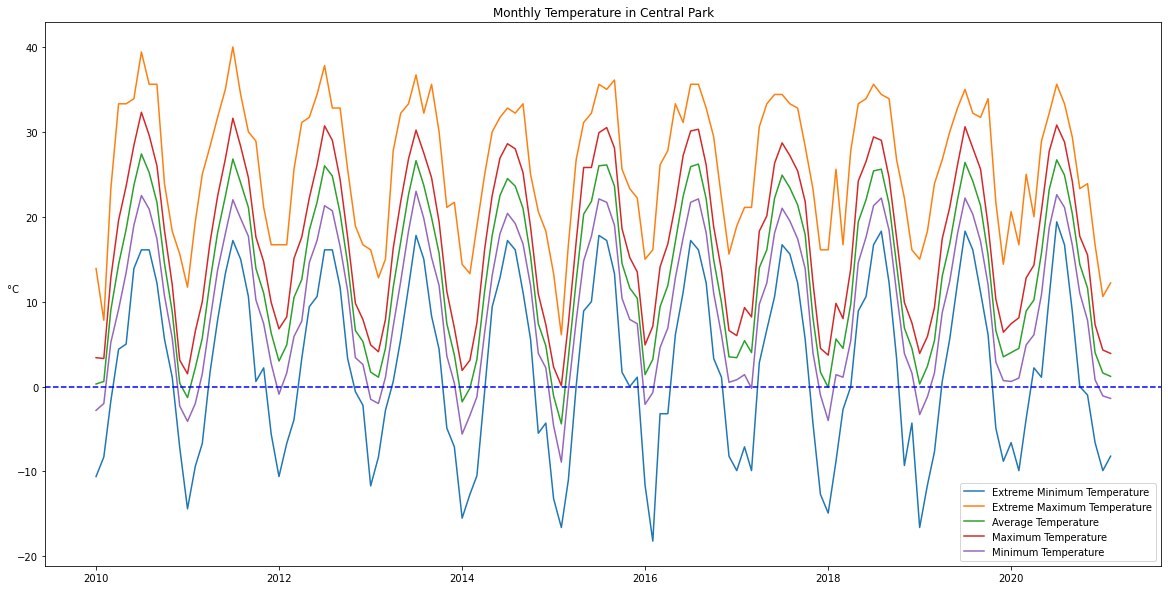

In [52]:
# plotting temperature data
fig=plt.figure(facecolor='white', figsize=(20,10))

plt.plot(weather_central_park['Extreme Minimum Temperature'], label = "Extreme Minimum Temperature")
plt.plot(weather_central_park['Extreme Maximum Temperature'], label = "Extreme Maximum Temperature")
plt.plot(weather_central_park['Average Temperature'], label = "Average Temperature")
plt.plot(weather_central_park['Maximum Temperature'], label = "Maximum Temperature")
plt.plot(weather_central_park['Minimum Temperature'], label = "Minimum Temperature")

plt.axhline(y= 0, linestyle="--", color='blue')
plt.title("Monthly Temperature in Central Park")
plt.ylabel('°C', rotation=0)
plt.legend()
plt.show()

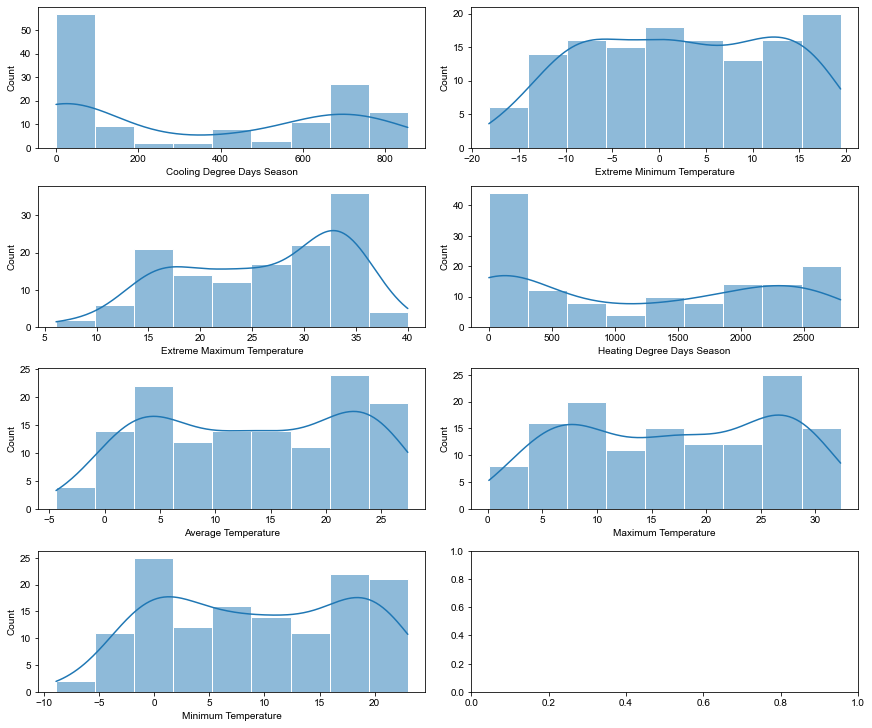

In [53]:
# plotting data distribution
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,10), constrained_layout=True)

for axx, column in zip(axes.flatten(), weather_central_park.columns):
    sns.set_style("white")
    sns.histplot(x=weather_central_park[column], data=weather_central_park, ax=axx, kde=True)

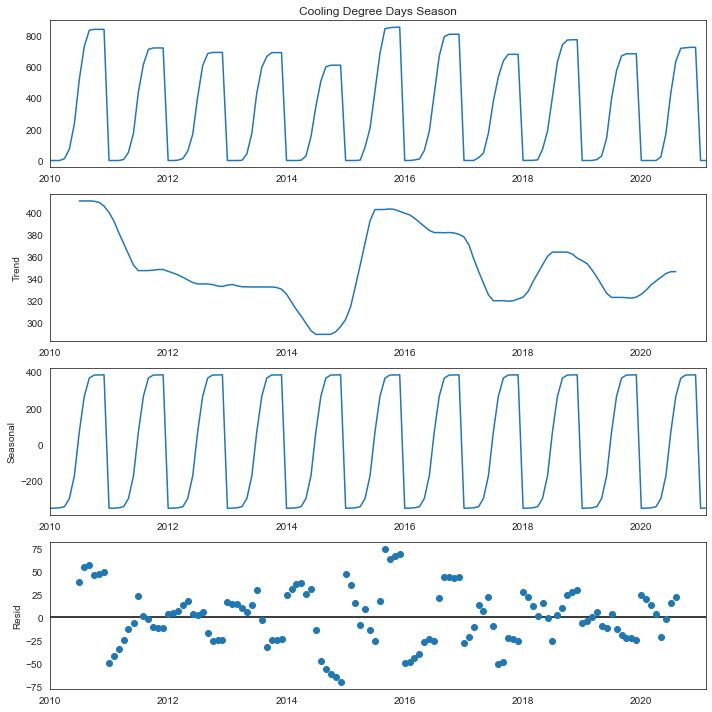

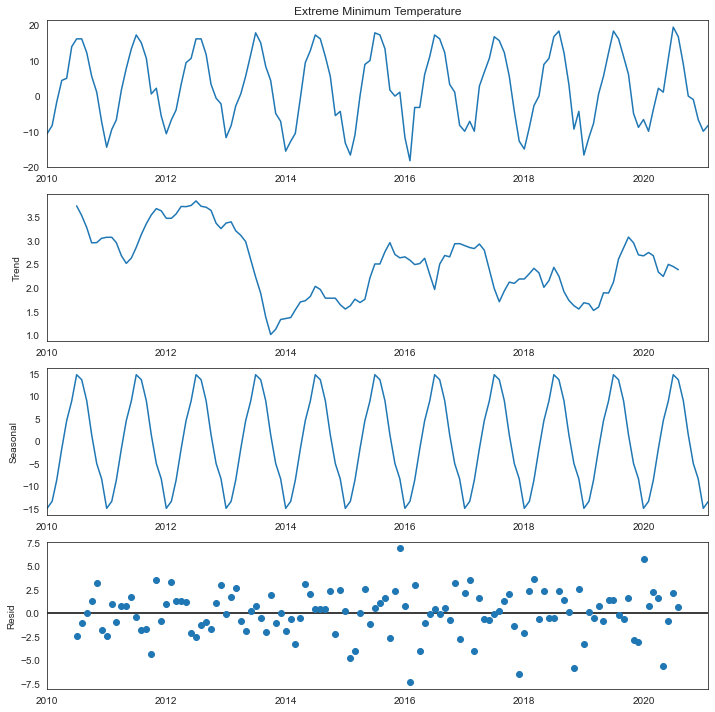

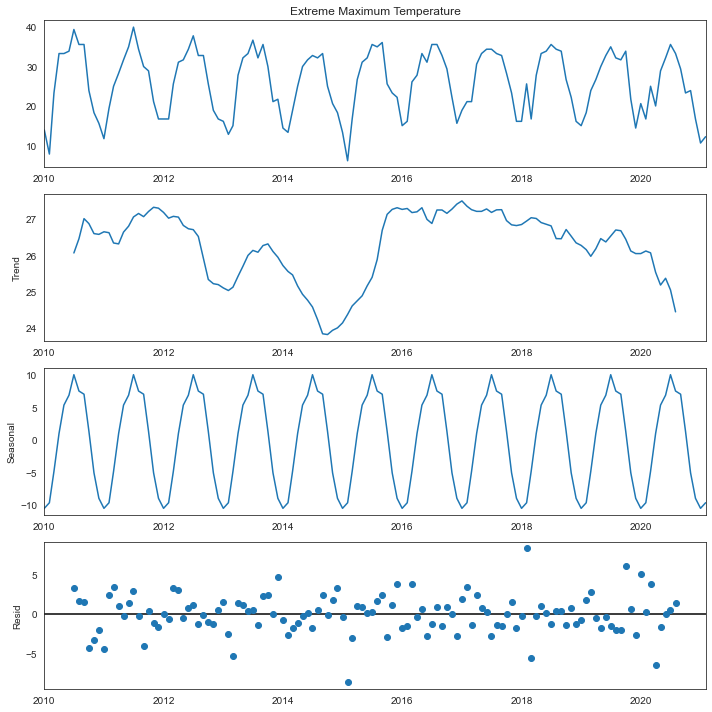

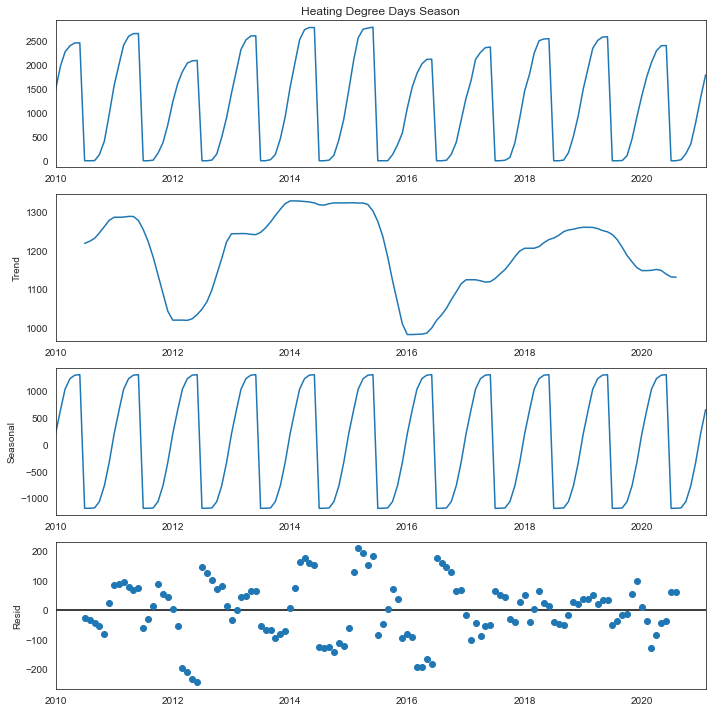

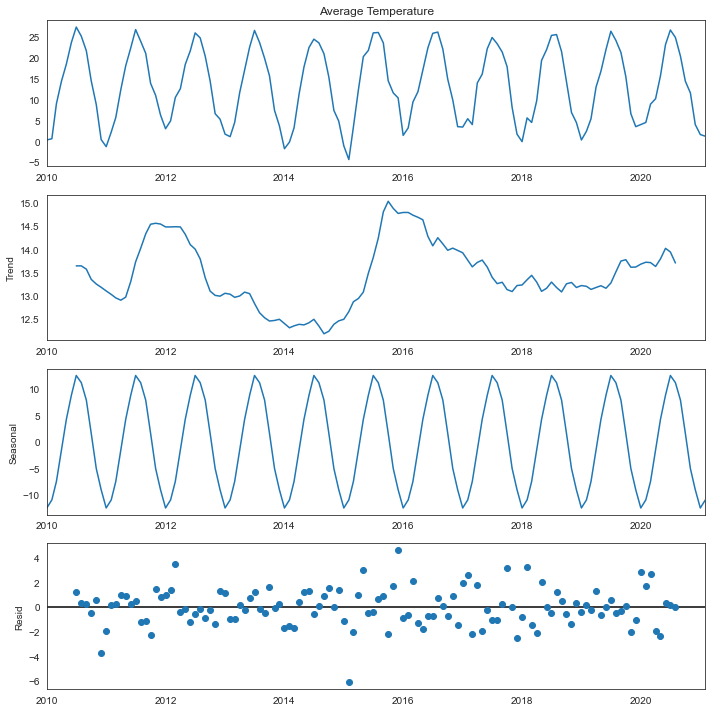

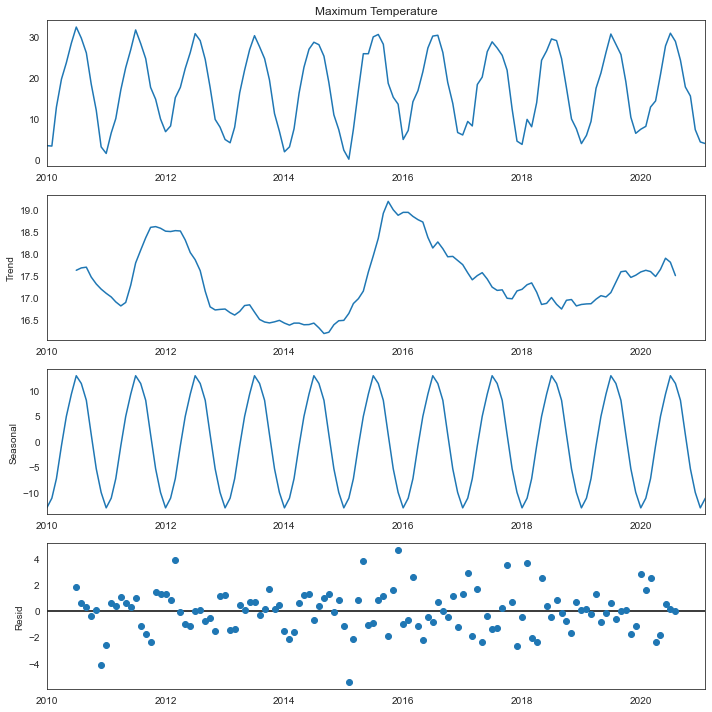

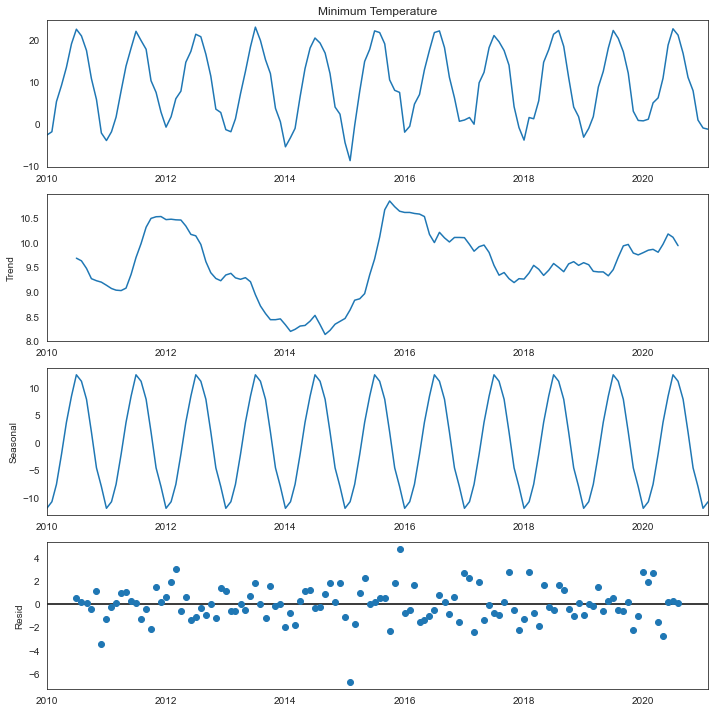

In [54]:
def decompose_time_series(series):
    plt.rcParams.update({'figure.figsize': (10,10)})
    result = seasonal_decompose(series, model='additive')
    result.plot()
    plt.show()

decompose_time_series(weather_central_park['Cooling Degree Days Season'])
decompose_time_series(weather_central_park['Extreme Minimum Temperature'])
decompose_time_series(weather_central_park['Extreme Maximum Temperature'])
decompose_time_series(weather_central_park['Heating Degree Days Season'])
decompose_time_series(weather_central_park['Average Temperature'])
decompose_time_series(weather_central_park['Maximum Temperature'])
decompose_time_series(weather_central_park['Minimum Temperature'])

>There is an upward trend in all temperature variables. It must be global warming effect.

## Merge Datasets

In [55]:
manhattan_data = electric_manhattan.merge(weather_central_park, left_index=True, right_index=True)
manhattan_data

Consumption (KWH)  Cooling Degree Days Season  \
DATE                                                        
2010-01-01       49050.579200                         0.0   
2010-02-01       42389.737757                         0.0   
2010-03-01       40492.149606                         0.0   
2010-04-01       40533.979528                        11.9   
2010-05-01       41163.179528                        73.6   
...                       ...                         ...   
2020-10-01       29538.725806                       722.3   
2020-11-01       28885.369089                       725.4   
2020-12-01       32497.295271                       725.4   
2021-01-01       32455.273356                         0.0   
2021-02-01       28880.169355                         0.0   

            Extreme Minimum Temperature  Extreme Maximum Temperature  \
DATE                                                                   
2010-01-01                        -10.6                         13.9   
2010-02-01                         -8.3                          7.8   
2010-03-01                         -1.7                         23.3   
2010-04-01                          4.4                         33.3   
2010-05-01                          5.0                         33.3   
...                                 ...                          ...   
2020-10-01                          0.0                         23.3   
2020-11-01                         -1.0                         23.9   
2020-12-01                         -6.6                         16.7   
2021-01-01                         -9.9                         10.6   
2021-02-01                         -8.2                         12.2   

            Heating Degree Days Season  Average Temperature  \
DATE                                                          
2010-01-01                      1487.8                  0.3   
2010-02-01                      1983.7                  0.6   
2010-03-01                      2273.1                  9.0   
2010-04-01                      2404.0                 14.4   
2010-05-01                      2461.0                 18.5   
...                                ...                  ...   
2020-10-01                       146.8                 14.4   
2020-11-01                       350.6                 11.6   
2020-12-01                       794.1                  4.0   
2021-01-01                      1314.0                  1.6   
2021-02-01                      1792.6                  1.2   

            Maximum Temperature  Minimum Temperature  
DATE                                                  
2010-01-01                  3.4                 -2.8  
2010-02-01                  3.3                 -2.0  
2010-03-01                 12.8                  5.2  
2010-04-01                 19.6                  9.1  
2010-05-01                 23.6                 13.4  
...                         ...                  ...  
2020-10-01                 17.7                 11.0  
2020-11-01                 15.5                  7.8  
2020-12-01                  7.3                  0.8  
2021-01-01                  4.3                 -1.1  
2021-02-01                  3.9                 -1.4  

[134 rows x 8 columns]

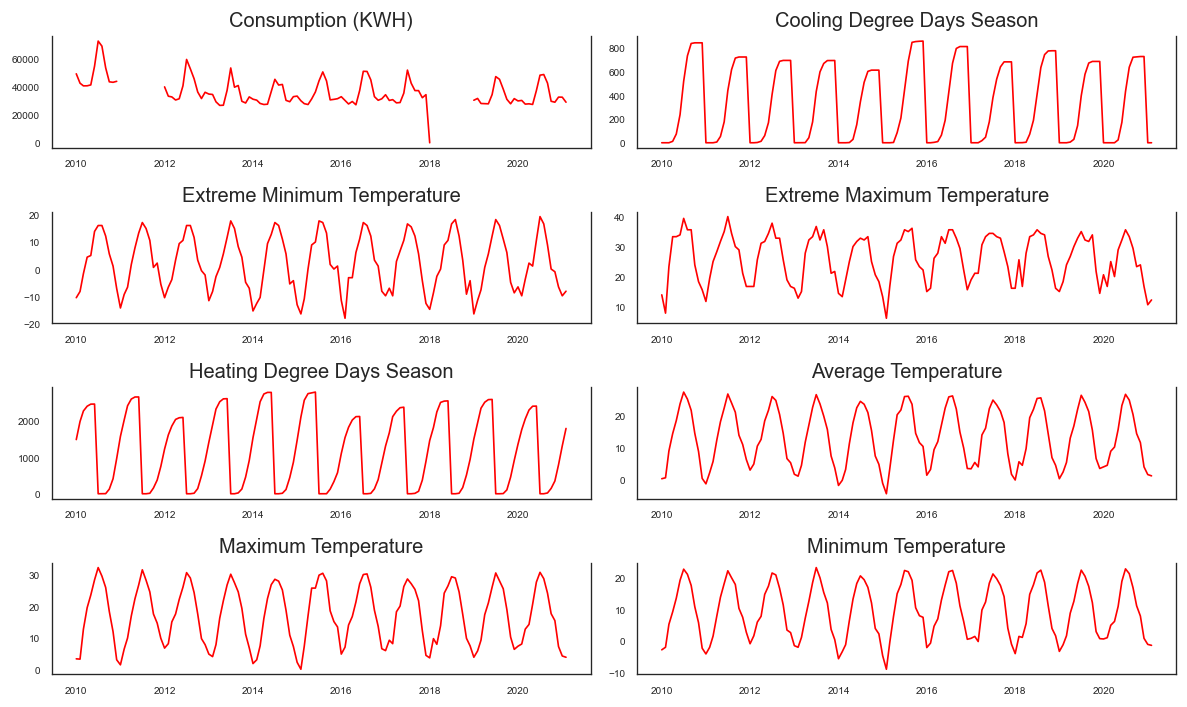

In [56]:
# plotting time series
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    data = manhattan_data[manhattan_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    
    ax.set_title(manhattan_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

>It is clear that all the time series have seasonality. 

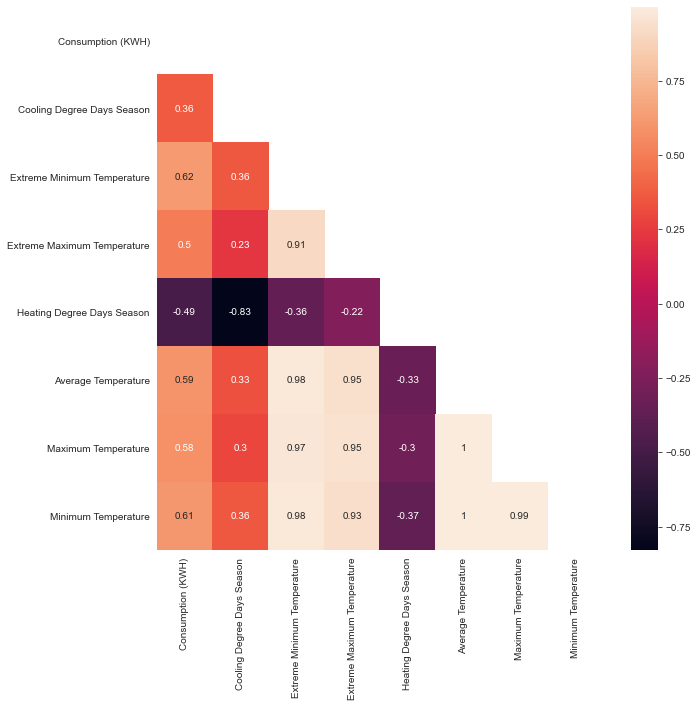

In [57]:
corr = manhattan_data.corr()

fig, axes = plt.subplots(figsize=(10,10))

sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)), annot=True);

>It looks like 'Consumption (KWH)' is correlated with 'Extreme Minimum Temperature' and 'Minimum Temperature' the most.

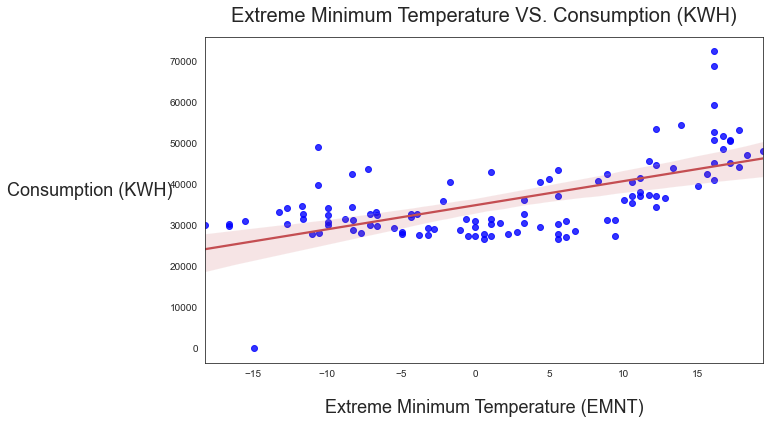

In [58]:
# plotting 'Extreme Minimum Temperature' vs. 'Consumption (KWH)'
sns.set_style("white")
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.set(font_scale=1.4)

sns.regplot(x=manhattan_data['Extreme Minimum Temperature'], 
            y=manhattan_data['Consumption (KWH)'], 
            ci=99, 
            scatter_kws={"color": "blue"}, 
            line_kws={"color": "r"})

ax.set_xlabel("Extreme Minimum Temperature (EMNT)", fontsize=18, labelpad=20)
ax.set_ylabel("Consumption (KWH)", fontsize=18, labelpad=80, rotation=0)
ax.set_title("Extreme Minimum Temperature VS. Consumption (KWH)", fontsize=20, pad=15);

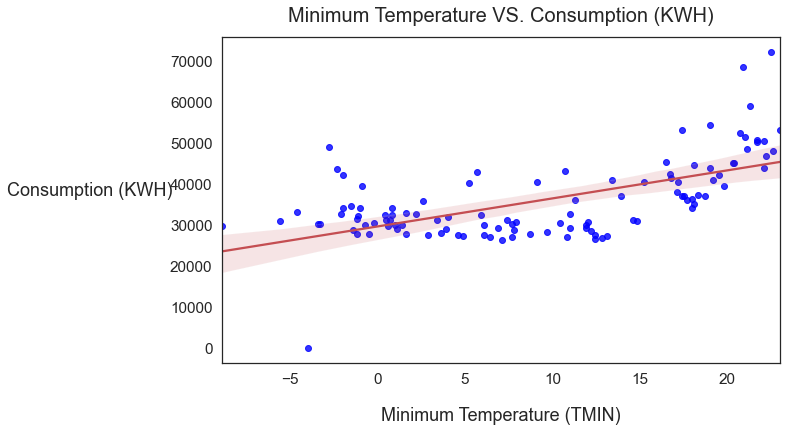

In [59]:
# plotting 'Minimum Temperature' vs. 'Consumption (KWH)'
sns.set_style("white")
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.set(font_scale=1.4)

sns.regplot(x=manhattan_data['Minimum Temperature'], 
            y=manhattan_data['Consumption (KWH)'], 
            ci=99, 
            scatter_kws={"color": "blue"}, 
            line_kws={"color": "r"})

ax.set_xlabel("Minimum Temperature (TMIN)", fontsize=18, labelpad=20)
ax.set_ylabel("Consumption (KWH)", fontsize=18, labelpad=80, rotation=0)
ax.set_title("Minimum Temperature VS. Consumption (KWH)", fontsize=20, pad=15);

In [60]:
manhattan_data.isna().sum()

Consumption (KWH)              23
Cooling Degree Days Season      0
Extreme Minimum Temperature     0
Extreme Maximum Temperature     0
Heating Degree Days Season      0
Average Temperature             0
Maximum Temperature             0
Minimum Temperature             0
dtype: int64

In [61]:
manhattan_data.loc[manhattan_data['Consumption (KWH)'].isna()]

Consumption (KWH)  Cooling Degree Days Season  \
DATE                                                        
2011-01-01                NaN                         0.0   
2011-02-01                NaN                         0.0   
2011-03-01                NaN                         0.0   
2011-04-01                NaN                         6.1   
2011-05-01                NaN                        52.8   
2011-06-01                NaN                       176.0   
2011-07-01                NaN                       438.7   
2011-08-01                NaN                       615.5   
2011-09-01                NaN                       712.5   
2011-10-01                NaN                       721.4   
2011-11-01                NaN                       721.4   
2011-12-01                NaN                       721.4   
2018-02-01                NaN                         0.9   
2018-03-01                NaN                         0.9   
2018-04-01                NaN                         4.3   
2018-05-01                NaN                        71.9   
2018-06-01                NaN                       189.4   
2018-07-01                NaN                       406.9   
2018-08-01                NaN                       632.9   
2018-09-01                NaN                       741.5   
2018-10-01                NaN                       772.3   
2018-11-01                NaN                       774.0   
2018-12-01                NaN                       774.0   

            Extreme Minimum Temperature  Extreme Maximum Temperature  \
DATE                                                                   
2011-01-01                        -14.4                         11.7   
2011-02-01                         -9.4                         19.4   
2011-03-01                         -6.7                         25.0   
2011-04-01                          1.7                         28.3   
2011-05-01                          7.8                         31.7   
2011-06-01                         13.3                         35.0   
2011-07-01                         17.2                         40.0   
2011-08-01                         15.0                         34.4   
2011-09-01                         10.6                         30.0   
2011-10-01                          0.6                         28.9   
2011-11-01                          2.2                         21.1   
2011-12-01                         -5.6                         16.7   
2018-02-01                         -8.8                         25.6   
2018-03-01                         -2.7                         16.7   
2018-04-01                          0.0                         27.8   
2018-05-01                          8.9                         33.3   
2018-06-01                         10.6                         33.9   
2018-07-01                         16.7                         35.6   
2018-08-01                         18.3                         34.4   
2018-09-01                         12.2                         33.9   
2018-10-01                          3.3                         26.7   
2018-11-01                         -9.3                         22.2   
2018-12-01                         -4.3                         16.1   

            Heating Degree Days Season  Average Temperature  \
DATE                                                          
2011-01-01                      1575.2                 -1.3   
2011-02-01                      2025.9                  2.2   
2011-03-01                      2416.5                  5.7   
2011-04-01                      2601.1                 12.4   
2011-05-01                      2656.7                 18.1   
2011-06-01                      2657.9                 22.4   
2011-07-01                         0.0                 26.8   
2011-08-01                         0.0                 24.0   
2011-09-01                        13.0                 

In [62]:
manhattan_data = manhattan_data.dropna()

>As mentioned earlier, there are missing data in the consumption column in 2011 and 2018. I will use 2012-2016 as a train set version1 and 2017 as a validation set, 2012-2017 as a train set version2, and 2019 and onward as a test set.

## Granger’s Causality Test

For the first model, I will use Vector AutoRegression(VAR). The basis behind VAR is that each of the time series in the dataset influences each other. 

Using Granger’s causality test, it’s possible to test this relationship before even building the model. It tests the null hypothesis that the past values of time series(x) DO NOT cause the other series(y). 

If the p-value obtained from the test is lesser than the significance level(e.g 0.05), then, you can reject the null hypothesis and indicate that the past values of time series(x) DO cause the other series(y).

The below code implements the Granger’s causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

In [63]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(manhattan_data, variables = manhattan_data.columns)

Consumption (KWH)_x  \
Consumption (KWH)_y                         1.0000   
Cooling Degree Days Season_y                0.0000   
Extreme Minimum Temperature_y               0.0197   
Extreme Maximum Temperature_y               0.0089   
Heating Degree Days Season_y                0.0000   
Average Temperature_y                       0.0435   
Maximum Temperature_y                       0.0416   
Minimum Temperature_y                       0.0542   

                               Cooling Degree Days Season_x  \
Consumption (KWH)_y                                     0.0   
Cooling Degree Days Season_y                            1.0   
Extreme Minimum Temperature_y                           0.0   
Extreme Maximum Temperature_y                           0.0   
Heating Degree Days Season_y                            0.0   
Average Temperature_y                                   0.0   
Maximum Temperature_y                                   0.0   
Minimum Temperature_y                                   0.0   

                               Extreme Minimum Temperature_x  \
Consumption (KWH)_y                                   0.0000   
Cooling Degree Days Season_y                          0.0000   
Extreme Minimum Temperature_y                         1.0000   
Extreme Maximum Temperature_y                         0.0000   
Heating Degree Days Season_y                          0.0000   
Average Temperature_y                                 0.0036   
Maximum Temperature_y                                 0.0013   
Minimum Temperature_y                                 0.0154   

                               Extreme Maximum Temperature_x  \
Consumption (KWH)_y                                   0.0000   
Cooling Degree Days Season_y                          0.0000   
Extreme Minimum Temperature_y                         0.0006   
Extreme Maximum Temperature_y                         1.0000   
Heating Degree Days Season_y                          0.0000   
Average Temperature_y                                 0.0398   
Maximum Temperature_y                                 0.0114   
Minimum Temperature_y                                 0.0091   

                               Heating Degree Days Season_x  \
Consumption (KWH)_y                                     0.0   
Cooling Degree Days Season_y                            0.0   
Extreme Minimum Temperature_y                           0.0   
Extreme Maximum Temperature_y                           0.0   
Heating Degree Days Season_y                            1.0   
Average Temperature_y                                   0.0   
Maximum Temperature_y                                   0.0   
Minimum Temperature_y                                   0.0   

                               Average Temperature_x  Maximum Temperature_x  \
Consumption (KWH)_y                              0.0                    0.0   
Cooling Degree Days Season_y                     0.0                    0.0   
Extreme Minimum Temperature_y                    0.0                    0.0   
Extreme Maximum Temperature_y                    0.0                    0.0   
Heating Degree Days Season_y                     0.0                    0.0   
Average Temperature_y                            1.0                    0.0   
Maximum Temperature_y                            0.0                    1.0   
Minimum Temperature_y                            0.0                    0.0   

                               Minimum Temperature_x  
Consumption (KWH)_y                              0.0  
Cooling Degree Days Season_y                     0.0  
Extreme Minimum Temperature_y                    0.0  
Extreme Maximum Temperature_y                    0.0  
Heating Degree Days Season_y                     0.0  
Average Temperature_y                            0.0  
Maximum Temperature_y                            0.0  
Minimum Temperature_y                            1.0

The rows are the response(y) and the columns are the predictor series(x). For example, if you take the value 0.0036 in (row 'TAVG_y', column 'EMNT_x'), it refers to the p-value of 'EMNT_x' causing 'TAVG_y'. 

Here, I am looking at the first row - the Consumption(KWH) as the target variable(y) and the rest of the variables as the predictors(x). The p-values are all zeros, which means that all the variables(time series) in the dataset are influencing the Consumption(KWH). Hence, I will keep them all and conduct train-validation-test split next. 

## Train-Validation-Test Split

In [64]:
data = manhattan_data['2012-01-01':'2017-12-01'] # 2nd version of the train set
train = data[:'2016-12-01']
val = data['2017-01-01':]
test = manhattan_data['2019-01-01':]

print('manhattan_data shape: ', manhattan_data.shape)
print('data shape: ', data.shape)
print('train shape: ', train.shape)
print('val shape: ', val.shape)
print('test shape: ', test.shape)

manhattan_data shape:  (111, 8)
data shape:  (72, 8)
train shape:  (60, 8)
val shape:  (12, 8)
test shape:  (26, 8)


In [65]:
type(data), type(train), type(val), type(test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [66]:
train.describe()

Consumption (KWH)  Cooling Degree Days Season  \
count          60.000000                   60.000000   
mean        35399.410211                  348.221667   
std          7842.712856                  329.796544   
min         26606.349171                    0.000000   
25%         30061.195838                    2.075000   
50%         32718.021920                  276.450000   
75%         39960.429771                  685.475000   
max         59260.691530                  855.300000   

       Extreme Minimum Temperature  Extreme Maximum Temperature  \
count                    60.000000                    60.000000   
mean                      2.503333                    25.921667   
std                      10.302558                     7.980550   
min                     -18.200000                     6.100000   
25%                      -5.050000                    18.750000   
50%                       2.500000                    27.250000   
75%                      11.250000                    32.800000   
max                      17.800000                    37.800000   

       Heating Degree Days Season  Average Temperature  Maximum Temperature  \
count                   60.000000            60.000000            60.000000   
mean                  1180.893333            13.440000            17.420000   
std                   1045.287468             8.962506             9.271129   
min                      0.000000            -4.400000             0.100000   
25%                     92.625000             4.875000             7.900000   
50%                   1008.900000            13.550000            17.600000   
75%                   2098.375000            21.875000            26.100000   
max                   2791.800000            26.600000            30.700000   

       Minimum Temperature  
count             60.00000  
mean               9.43500  
std                8.69026  
min               -8.90000  
25%                2.05000  
50%                9.15000  
75%               17.55000  
max               23.00000

In [67]:
# lengths of val set and test set
nobs = len(val)
test_nobs = len(test)

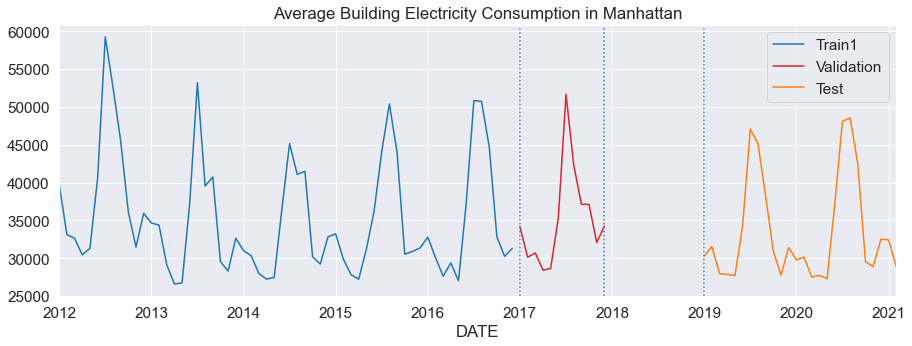

In [68]:
# 1st version of the train set
ax = train["Consumption (KWH)"].plot(figsize=(15,5), color="tab:blue", label='Train1')
_ = val["Consumption (KWH)"].plot(ax=ax, color="tab:red", label='Validation')
_ = test["Consumption (KWH)"].plot(ax=ax, color="tab:orange", label='Test')

plt.title("Average Building Electricity Consumption in Manhattan")
ax.legend()
ax.axvline(val.index[0], linestyle=":")
ax.axvline(val.index[-1], linestyle=":")
ax.axvline(test.index[0], linestyle=":");

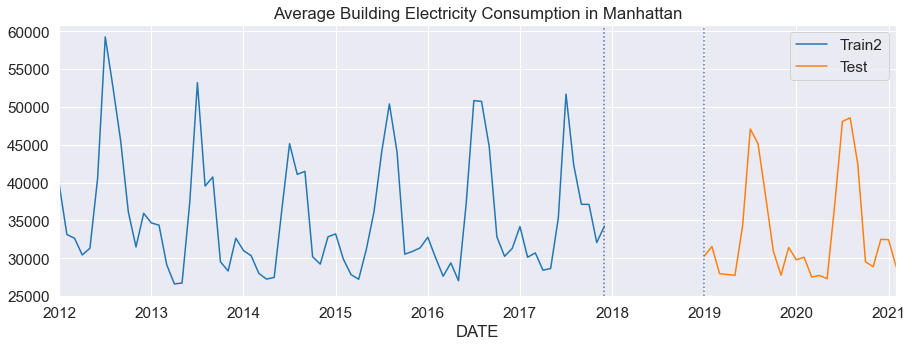

In [69]:
# 2nd version of the train set
ax = data["Consumption (KWH)"].plot(figsize=(15,5), color="tab:blue", label='Train2')
_ = test["Consumption (KWH)"].plot(ax=ax, color="tab:orange", label='Test')

plt.title("Average Building Electricity Consumption in Manhattan")
ax.legend()
ax.axvline(data.index[-1], linestyle=":")
ax.axvline(test.index[0], linestyle=":");

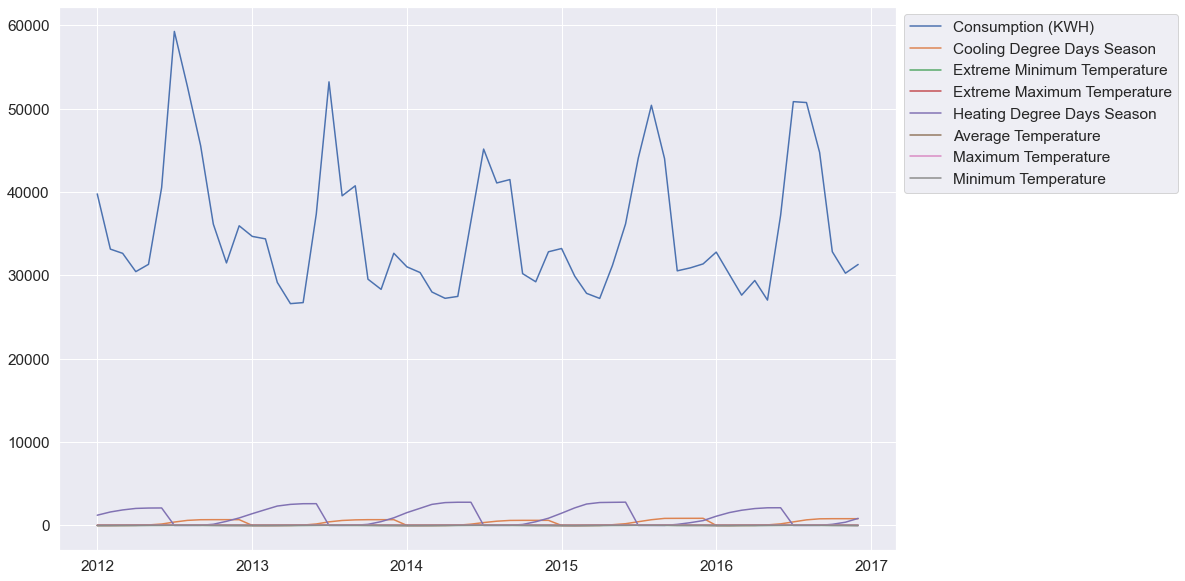

In [70]:
# plotting 1st version train set
fig, axes = plt.subplots(figsize=(15,10))

plt.plot(train)
plt.legend(train.columns, loc='upper left', bbox_to_anchor=(1, 1));

# Data Preprocessing

## Stationarity 

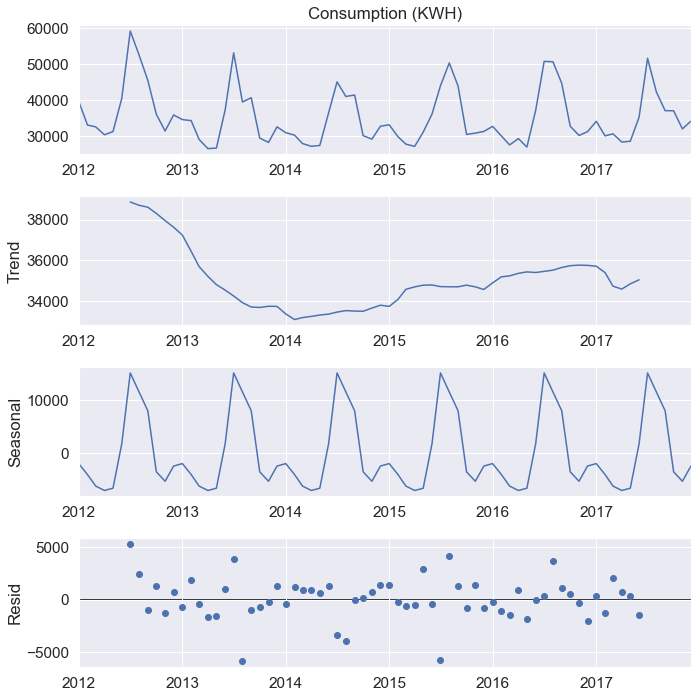

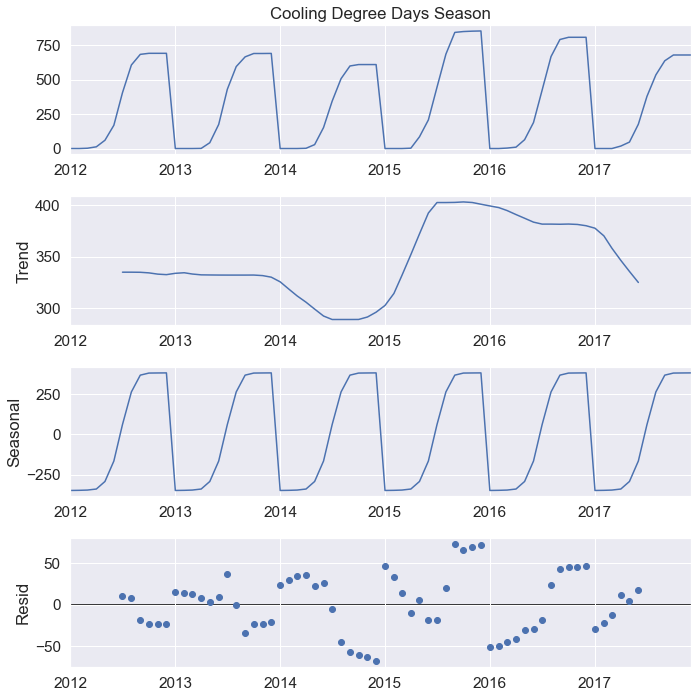

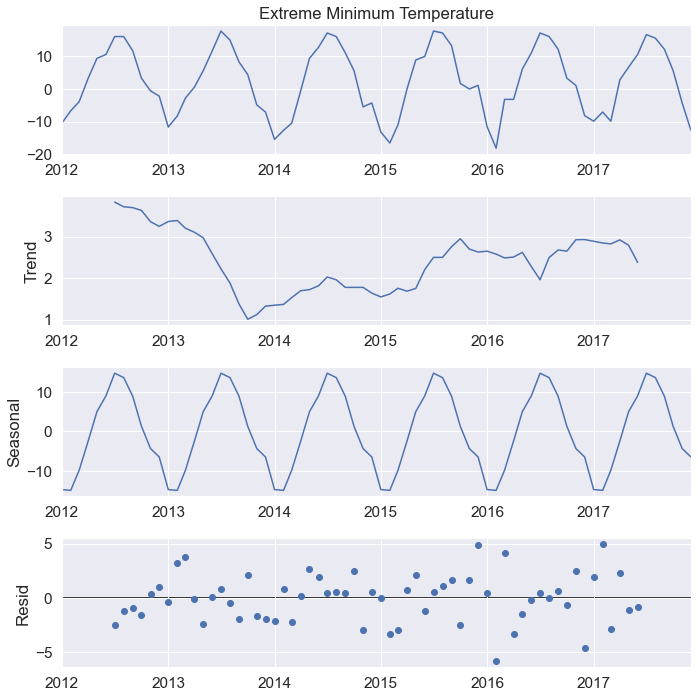

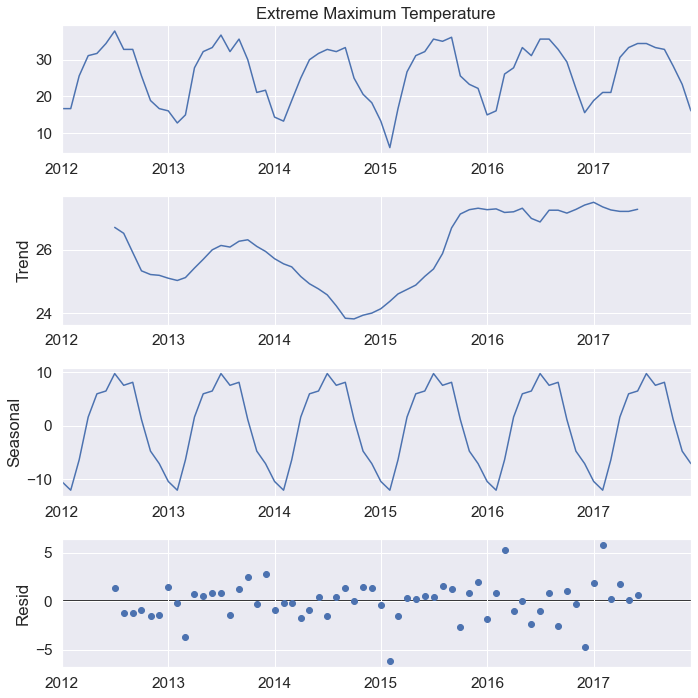

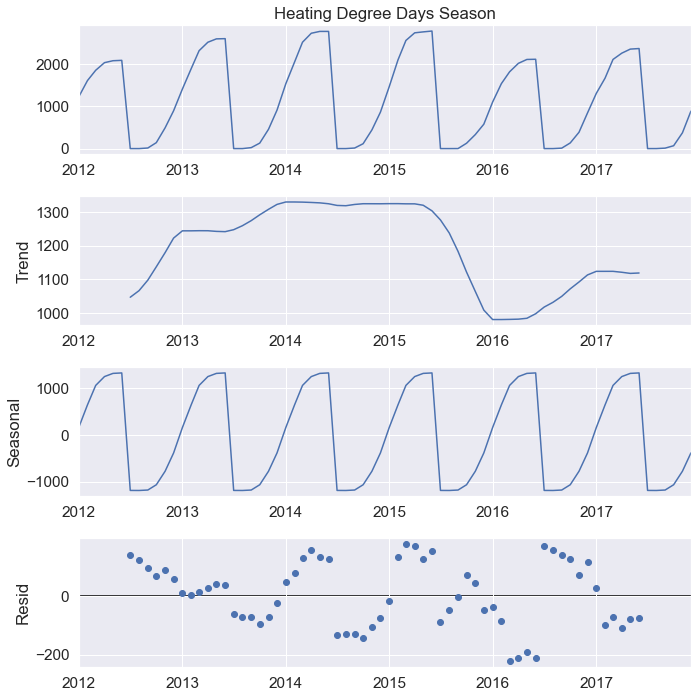

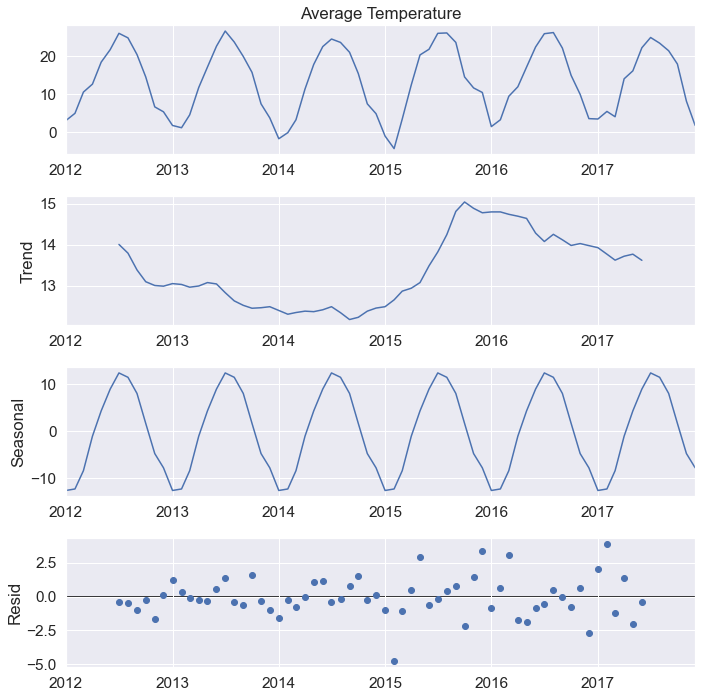

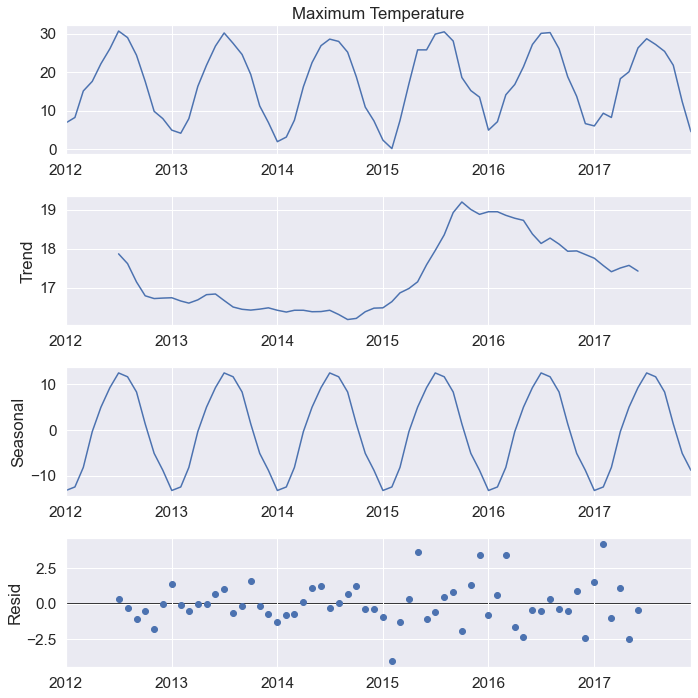

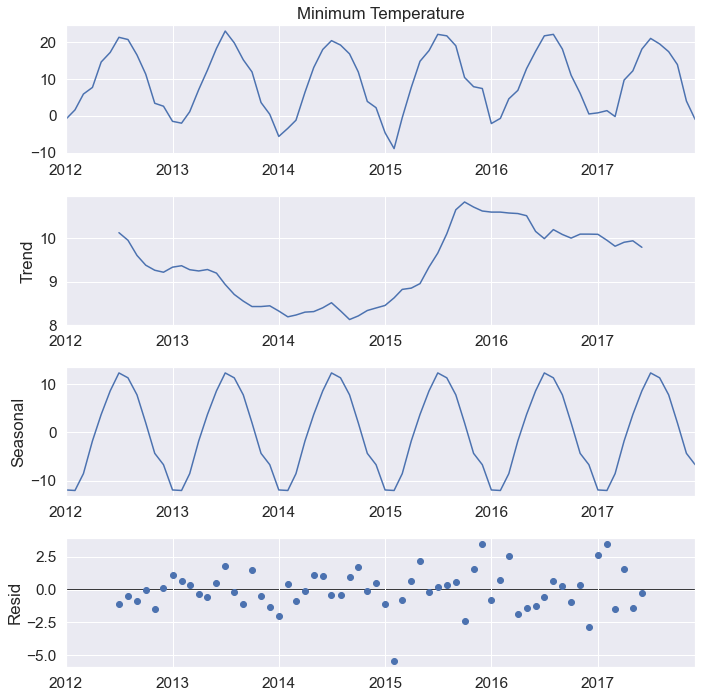

In [71]:
decompose_time_series(data['Consumption (KWH)'])
decompose_time_series(data['Cooling Degree Days Season'])
decompose_time_series(data['Extreme Minimum Temperature'])
decompose_time_series(data['Extreme Maximum Temperature'])
decompose_time_series(data['Heating Degree Days Season'])
decompose_time_series(data['Average Temperature'])
decompose_time_series(data['Maximum Temperature'])
decompose_time_series(data['Minimum Temperature'])

In [72]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    def adjust(val, length=6): 
        return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [73]:
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Consumption (KWH)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5231
 No. Lags Chosen       = 12
 Critical value 1%     = -3.546
 Critical value 5%     = -2.912
 Critical value 10%    = -2.594
 => P-Value = 0.11. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Cooling Degree Days Season" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4688
 No. Lags Chosen       = 12
 Critical value 1%     = -3.546
 Critical value 5%     = -2.912
 Critical value 10%    = -2.594
 => P-Value = 0.1232. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Extreme Minimum Temperature" 
    ------------------------

In [74]:
# first 1 lag differencing 
data_differenced = data.diff().dropna()

In [75]:
for name, column in data_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Consumption (KWH)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8784
 No. Lags Chosen       = 11
 Critical value 1%     = -3.546
 Critical value 5%     = -2.912
 Critical value 10%    = -2.594
 => P-Value = 0.0022. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Cooling Degree Days Season" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4027
 No. Lags Chosen       = 11
 Critical value 1%     = -3.546
 Critical value 5%     = -2.912
 Critical value 10%    = -2.594
 => P-Value = 0.581. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Extreme Minimum Temperature" 
    ---------------------------------------------

>Not all of them are stationary yet. I will try differencing one more time.

In [76]:
# Second 1 lag differencing 
data_differenced = data_differenced.diff().dropna()

In [77]:
for name, column in data_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Consumption (KWH)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2692
 No. Lags Chosen       = 11
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Cooling Degree Days Season" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -38.5237
 No. Lags Chosen       = 10
 Critical value 1%     = -3.546
 Critical value 5%     = -2.912
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Extreme Minimum Temperature" 
    -----------------------------------------------
 Null Hypothesis: Data 

>All of them are stationary now.

In [78]:
# differencing version 1 train set
# first 1 lag differencing 
df_differenced = train.diff().dropna()

In [79]:
# Second 1 lag differencing 
df_differenced = df_differenced.diff().dropna()

# Modeling

I will train the data using VAR(Vector Autoregression), VARMAX(Vector Autoregression Moving-Average with Exogenous Regressors) and LSTM(Long Short Term Memory) models. For the evaluation metrics, I will focus on RMSE(Root Mean Squared Error), which will show how much kWh are off, and MAPE(Mean Average Percentage Error), which will expresses the forecast error by how many percentage points the forecasts are off on average. 

## VAR Model

The Vector Autoregression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other.

### Using Train Set Version 1

In [80]:
# instantiating VAR model
var_model = VAR(df_differenced)

# finding optimal order(p) of the VAR model
var_model.select_order().summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.table.SimpleTable'>

>The optimal lag is observed at a lag order of 5.

In [81]:
var_result = var_model.fit(5)
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Sep, 2021
Time:                     16:17:30
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    36.1273
Nobs:                     53.0000    HQIC:                   28.6228
Log likelihood:          -907.876    FPE:                1.48073e+12
AIC:                      23.9338    Det(Omega_mle):     1.51238e+10
--------------------------------------------------------------------
Results for equation Consumption (KWH)
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                -74.614850       289.454336           -0.258           0.797
L1.Consumption (KWH)                  -0.720929         0.135593           -5.

In [82]:
# getting the lag order
lag_order = var_result.k_ar
print(lag_order)  

# input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

5


array([[-1.37329737e+04,  8.70000000e+00, -7.20000000e+00,
        -4.50000000e+00,  2.12150000e+03, -3.20000000e+00,
        -2.70000000e+00, -3.80000000e+00],
       [-5.87072382e+03, -1.20300000e+02, -2.80000000e+00,
        -2.80000000e+00,  1.06000000e+01, -4.40000000e+00,
        -4.40000000e+00, -4.40000000e+00],
       [-5.93893873e+03, -1.07900000e+02, -5.00000000e+00,
        -6.00000000e-01,  1.12900000e+02, -3.10000000e+00,
        -3.10000000e+00, -3.10000000e+00],
       [ 9.34308217e+03, -1.61000000e+01,  6.70000000e+00,
        -3.80000000e+00,  1.30500000e+02,  2.20000000e+00,
         2.20000000e+00,  2.20000000e+00],
       [ 3.62221138e+03,  0.00000000e+00, -7.10000000e+00,
         6.00000000e-01,  2.04600000e+02, -1.40000000e+00,
        -2.00000000e+00, -7.00000000e-01]])

In [83]:
# forecasting
var_pred = var_result.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(var_pred, index=data.index[-nobs:], columns=data.columns + '_2d')
df_forecast

Consumption (KWH)_2d  Cooling Degree Days Season_2d  \
DATE                                                              
2017-01-01          10048.079349                    -559.789368   
2017-02-01         -21428.619086                     446.244659   
2017-03-01           4338.232557                      59.840656   
2017-04-01           3197.900732                      98.979888   
2017-05-01           3653.705992                     -63.349063   
2017-06-01          17450.582668                     210.559842   
2017-07-01         -16874.075444                    -117.938836   
2017-08-01          -3394.369821                     111.772335   
2017-09-01          -1076.327497                     110.787361   
2017-10-01          -8611.102995                    -381.116313   
2017-11-01          11552.823373                      59.377026   
2017-12-01           2127.209554                     119.320891   

            Extreme Minimum Temperature_2d  Extreme Maximum Temperature_2d  \
DATE                                                                         
2017-01-01                        4.895119                       12.907195   
2017-02-01                        2.513900                      -16.897314   
2017-03-01                        4.202308                       15.477686   
2017-04-01                       -0.658933                        5.897281   
2017-05-01                       12.437010                      -10.014881   
2017-06-01                      -14.432602                        4.985419   
2017-07-01                        5.432065                       -3.553500   
2017-08-01                       -7.306630                       -9.247682   
2017-09-01                        1.245983                       14.687331   
2017-10-01                       -6.973768                      -16.303826   
2017-11-01                       -3.097947                        0.647080   
2017-12-01                        9.476727                       11.280344   

            Heating Degree Days Season_2d  Average Temperature_2d  \
DATE                                                                
2017-01-01                    -142.315741                4.855177   
2017-02-01                     156.171158               -0.814898   
2017-03-01                     398.125782                1.623034   
2017-04-01                    -864.423049                7.973522   
2017-05-01                     164.350632               -0.665107   
2017-06-01                     101.595421               -2.047035   
2017-07-01                   -2352.905442               -2.196893   
2017-08-01                    1405.899352               -5.534762   
2017-09-01                     968.612408                2.192221   
2017-10-01                    -121.482858               -4.933117   
2017-11-01                     117.491896               -3.104514   
2017-12-01                     281.339689                7.660311   

            Maximum Temperature_2d  Minimum Temperature_2d  
DATE                                                        
2017-01-01                5.578807                3.746367  
2017-02-01                0.439633               -1.577696  
2017-03-01                0.317848                2.827747  
2017-04-01                8.227996                7.441036  
2017-05-01                0.041133               -1.110028  
2017-06-01               -3.518252               -0.791657  
2017-07-01               -2.150008               -2.077395  
2017-08-01               -4.371605               -6.550388  
2017-09-01                1.117793                2.893127  
2017-10-01               -4.271667               -5.344684  
2017-11-01               -3.976133               -2.319512  
2017-12-01                7.875025                7.366862

>The forecasts are generated but it is on the scale of the training data used by the model. Thus, to bring it back up to its original scale, I need to de-difference it as many times I had differenced the original input data. In this case it is two times.

In [84]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

# inverted results in a dataframe
df_var_results = invert_transformation(train, df_forecast, second_diff=True)        
df_var_results

Consumption (KWH)_2d  Cooling Degree Days Season_2d  \
DATE                                                              
2017-01-01          10048.079349                    -559.789368   
2017-02-01         -21428.619086                     446.244659   
2017-03-01           4338.232557                      59.840656   
2017-04-01           3197.900732                      98.979888   
2017-05-01           3653.705992                     -63.349063   
2017-06-01          17450.582668                     210.559842   
2017-07-01         -16874.075444                    -117.938836   
2017-08-01          -3394.369821                     111.772335   
2017-09-01          -1076.327497                     110.787361   
2017-10-01          -8611.102995                    -381.116313   
2017-11-01          11552.823373                      59.377026   
2017-12-01           2127.209554                     119.320891   

            Extreme Minimum Temperature_2d  Extreme Maximum Temperature_2d  \
DATE                                                                         
2017-01-01                        4.895119                       12.907195   
2017-02-01                        2.513900                      -16.897314   
2017-03-01                        4.202308                       15.477686   
2017-04-01                       -0.658933                        5.897281   
2017-05-01                       12.437010                      -10.014881   
2017-06-01                      -14.432602                        4.985419   
2017-07-01                        5.432065                       -3.553500   
2017-08-01                       -7.306630                       -9.247682   
2017-09-01                        1.245983                       14.687331   
2017-10-01                       -6.973768                      -16.303826   
2017-11-01                       -3.097947                        0.647080   
2017-12-01                        9.476727                       11.280344   

            Heating Degree Days Season_2d  Average Temperature_2d  \
DATE                                                                
2017-01-01                    -142.315741                4.855177   
2017-02-01                     156.171158               -0.814898   
2017-03-01                     398.125782                1.623034   
2017-04-01                    -864.423049                7.973522   
2017-05-01                     164.350632               -0.665107   
2017-06-01                     101.595421               -2.047035   
2017-07-01                   -2352.905442               -2.196893   
2017-08-01                    1405.899352               -5.534762   
2017-09-01                     968.612408                2.192221   
2017-10-01                    -121.482858               -4.933117   
2017-11-01                     117.491896               -3.104514   
2017-12-01                     281.339689                7.660311   

            Maximum Temperature_2d  Minimum Temperature_2d  \
DATE                                                         
2017-01-01                5.578807                3.746367   
2017-02-01                0.439633               -1.577696   
2017-03-01                0.317848                2.827747   
2017-04-01                8.227996                7.441036   
2017-05-01                0.041133               -1.110028   
2017-06-01               -3.518252               -0.791657   
2017-07-01               -2.150008               -2.077395   
2017-08-01               -4.371605               -6.550388   
2017-09-01                1.117793                2.893127   
2017-10-01               -4.271667               -5.344684   
2017-11-01               -3.976133               -2.319512   
2017-12-01                7.875025                7.366862   

            Consumption (KWH)_1d  Consumption (KWH)_forecast  ...  \
DATE                                                          ...   
2017-0

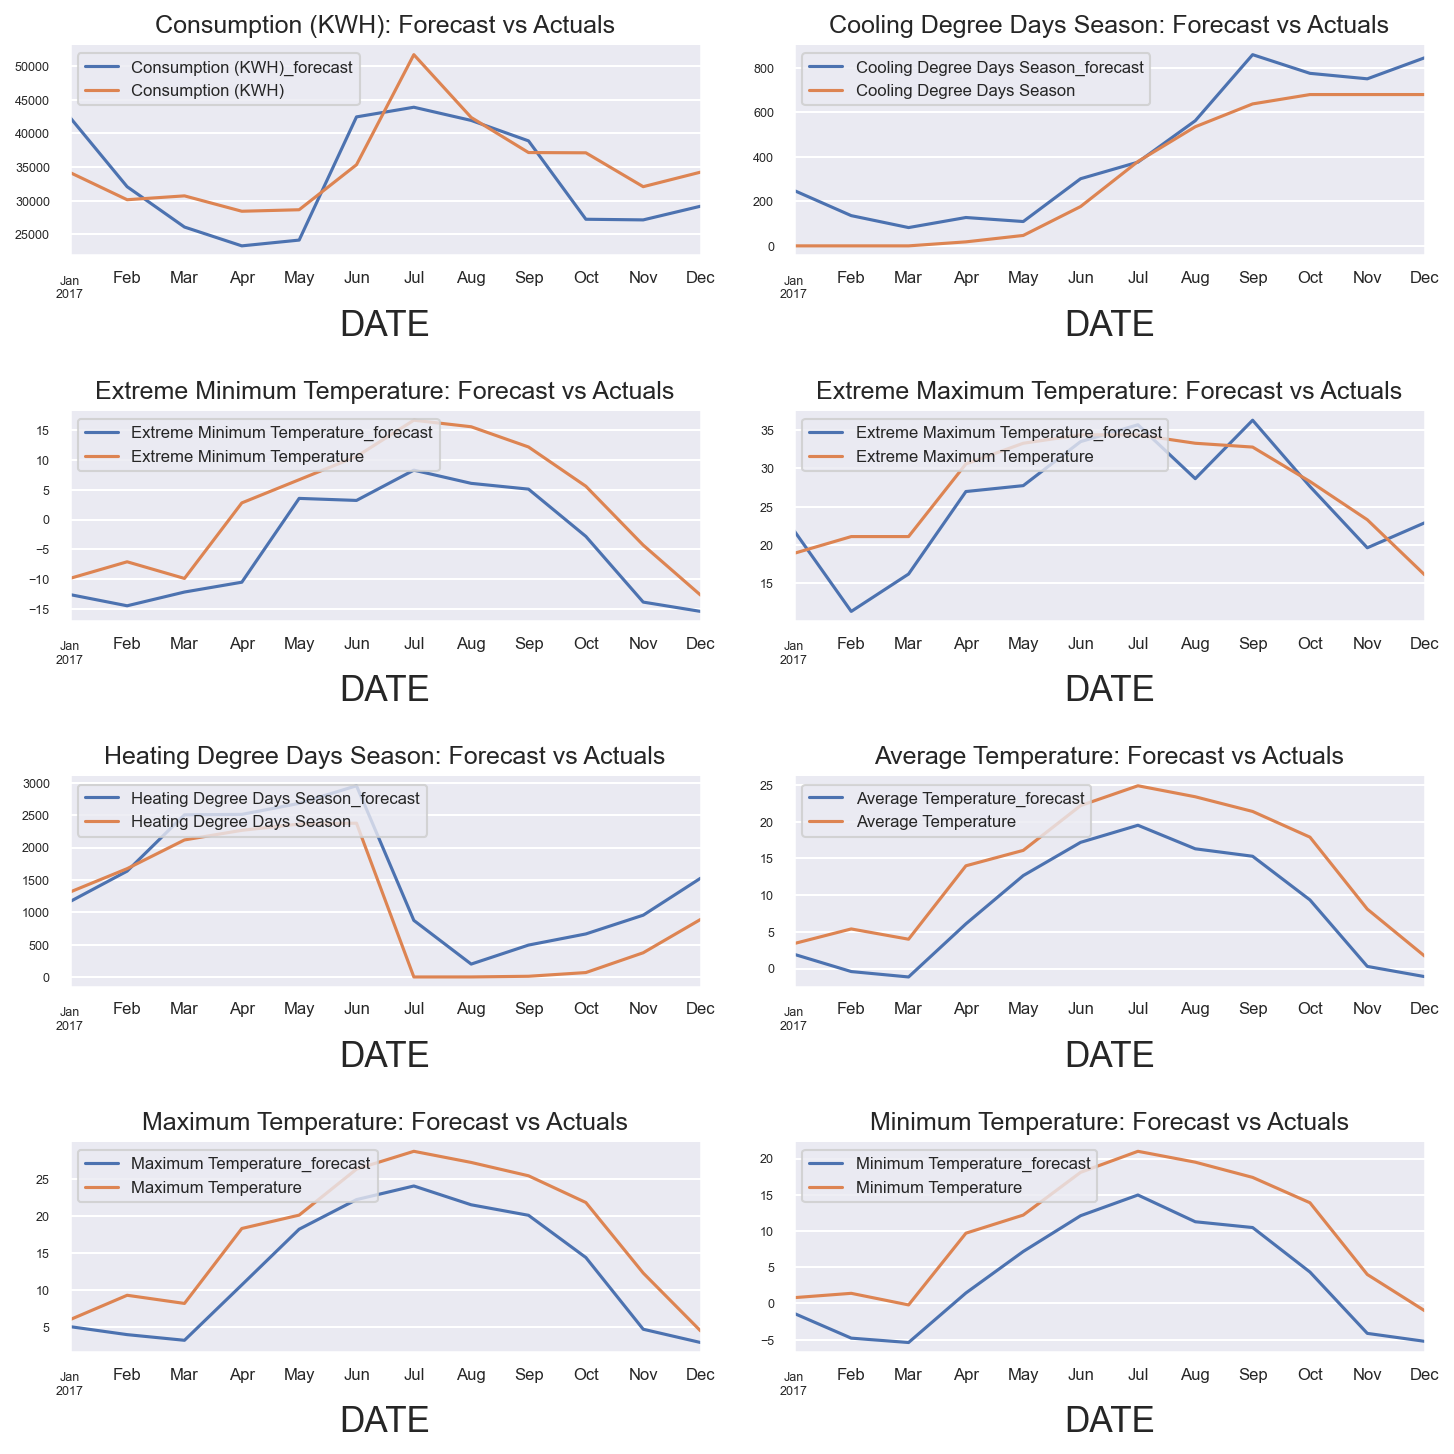

In [85]:
# plotting forecast vs actuals
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_var_results[col+'_forecast'].plot(legend=True, ax=ax, ).autoscale(axis='x',tight=True)
    val[col][-nobs:].plot(legend=True, ax=ax, fontsize=8)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [86]:
# evaluating the forecasts
def adjust(val, length= 6): 
    return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [87]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy = forecast_accuracy(df_var_results['Consumption (KWH)_forecast'].values, val['Consumption (KWH)'])
for k, v in accuracy.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.1476
me     :  -1952.1988
mae    :  5116.9098
mpe    :  -0.0555
rmse   :  5785.6718
corr   :  0.7153
minmax :  0.1404


<ipython-input-86-968d63a3b996>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-86-968d63a3b996>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [88]:
# tracking model performance
performance = []
performance.append('VAR val (train1) - RMSE: 5,785. MAPE: 15%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%']

>The VAR forecast for the electricity consumption is off by around 5,785 KWH. About 15% of forcasted data points are off on average. 

#### Predicting Test set

In [89]:
# forecasting
var_pred_test = var_result.forecast(y=forecast_input, steps=test_nobs)
df_forecast_test = pd.DataFrame(var_pred_test, index=manhattan_data.index[-test_nobs:], columns=manhattan_data.columns + '_2d')
df_forecast_test

Consumption (KWH)_2d  Cooling Degree Days Season_2d  \
DATE                                                              
2019-01-01          10048.079349                    -559.789368   
2019-02-01         -21428.619086                     446.244659   
2019-03-01           4338.232557                      59.840656   
2019-04-01           3197.900732                      98.979888   
2019-05-01           3653.705992                     -63.349063   
2019-06-01          17450.582668                     210.559842   
2019-07-01         -16874.075444                    -117.938836   
2019-08-01          -3394.369821                     111.772335   
2019-09-01          -1076.327497                     110.787361   
2019-10-01          -8611.102995                    -381.116313   
2019-11-01          11552.823373                      59.377026   
2019-12-01           2127.209554                     119.320891   
2020-01-01           -684.218636                    -709.745208   
2020-02-01          -9731.921300                     444.966520   
2020-03-01           5522.530580                     220.586259   
2020-04-01           2765.987795                    -119.842436   
2020-05-01           2113.470722                     141.413343   
2020-06-01           3613.512244                      72.309892   
2020-07-01            963.771570                    -145.962462   
2020-08-01          -2925.621577                     353.934773   
2020-09-01         -12104.939273                    -184.910092   
2020-10-01            635.019046                    -237.287663   
2020-11-01           4515.537925                     167.893221   
2020-12-01           1086.180939                    -195.065112   
2021-01-01           7351.910263                    -389.626420   
2021-02-01         -12891.181090                     308.146928   

            Extreme Minimum Temperature_2d  Extreme Maximum Temperature_2d  \
DATE                                                                         
2019-01-01                        4.895119                       12.907195   
2019-02-01                        2.513900                      -16.897314   
2019-03-01                        4.202308                       15.477686   
2019-04-01                       -0.658933                        5.897281   
2019-05-01                       12.437010                      -10.014881   
2019-06-01                      -14.432602                        4.985419   
2019-07-01                        5.432065                       -3.553500   
2019-08-01                       -7.306630                       -9.247682   
2019-09-01                        1.245983                       14.687331   
2019-10-01                       -6.973768                      -16.303826   
2019-11-01                       -3.097947                        0.647080   
2019-12-01                        9.476727                       11.280344   
2020-01-01                        0.028416                      -12.297663   
2020-02-01                      -12.036891                        3.397749   
2020-03-01                       21.264325                       17.758714   
2020-04-01                       -0.879561                      -10.767608   
2020-05-01                       -2.639261                        7.219423   
2020-06-01                        1.795512                       -7.770247   
2020-07-01                       -3.075863                       -3.206517   
2020-08-01                       -3.652110                        8.160877   
2020-09-01                       -0.922288                       -9.521889   
2020-10-01                      -12.076922                       -0.413744   
2020-11-01                       12.464936                        2.342360   
2020-12-01                       -2.456695                      -11.228040   
2021-01-01                       -9.177028                       15.534042   
2021-02-01                   

In [90]:
df_var_results_test = invert_transformation(train, df_forecast_test, second_diff=True)        
df_var_results_test

Consumption (KWH)_2d  Cooling Degree Days Season_2d  \
DATE                                                              
2019-01-01          10048.079349                    -559.789368   
2019-02-01         -21428.619086                     446.244659   
2019-03-01           4338.232557                      59.840656   
2019-04-01           3197.900732                      98.979888   
2019-05-01           3653.705992                     -63.349063   
2019-06-01          17450.582668                     210.559842   
2019-07-01         -16874.075444                    -117.938836   
2019-08-01          -3394.369821                     111.772335   
2019-09-01          -1076.327497                     110.787361   
2019-10-01          -8611.102995                    -381.116313   
2019-11-01          11552.823373                      59.377026   
2019-12-01           2127.209554                     119.320891   
2020-01-01           -684.218636                    -709.745208   
2020-02-01          -9731.921300                     444.966520   
2020-03-01           5522.530580                     220.586259   
2020-04-01           2765.987795                    -119.842436   
2020-05-01           2113.470722                     141.413343   
2020-06-01           3613.512244                      72.309892   
2020-07-01            963.771570                    -145.962462   
2020-08-01          -2925.621577                     353.934773   
2020-09-01         -12104.939273                    -184.910092   
2020-10-01            635.019046                    -237.287663   
2020-11-01           4515.537925                     167.893221   
2020-12-01           1086.180939                    -195.065112   
2021-01-01           7351.910263                    -389.626420   
2021-02-01         -12891.181090                     308.146928   

            Extreme Minimum Temperature_2d  Extreme Maximum Temperature_2d  \
DATE                                                                         
2019-01-01                        4.895119                       12.907195   
2019-02-01                        2.513900                      -16.897314   
2019-03-01                        4.202308                       15.477686   
2019-04-01                       -0.658933                        5.897281   
2019-05-01                       12.437010                      -10.014881   
2019-06-01                      -14.432602                        4.985419   
2019-07-01                        5.432065                       -3.553500   
2019-08-01                       -7.306630                       -9.247682   
2019-09-01                        1.245983                       14.687331   
2019-10-01                       -6.973768                      -16.303826   
2019-11-01                       -3.097947                        0.647080   
2019-12-01                        9.476727                       11.280344   
2020-01-01                        0.028416                      -12.297663   
2020-02-01                      -12.036891                        3.397749   
2020-03-01                       21.264325                       17.758714   
2020-04-01                       -0.879561                      -10.767608   
2020-05-01                       -2.639261                        7.219423   
2020-06-01                        1.795512                       -7.770247   
2020-07-01                       -3.075863                       -3.206517   
2020-08-01                       -3.652110                        8.160877   
2020-09-01                       -0.922288                       -9.521889   
2020-10-01                      -12.076922                       -0.413744   
2020-11-01                       12.464936                        2.342360   
2020-12-01                       -2.456695                      -11.228040   
2021-01-01                       -9.177028                       15.534042   
2021-02-01                   

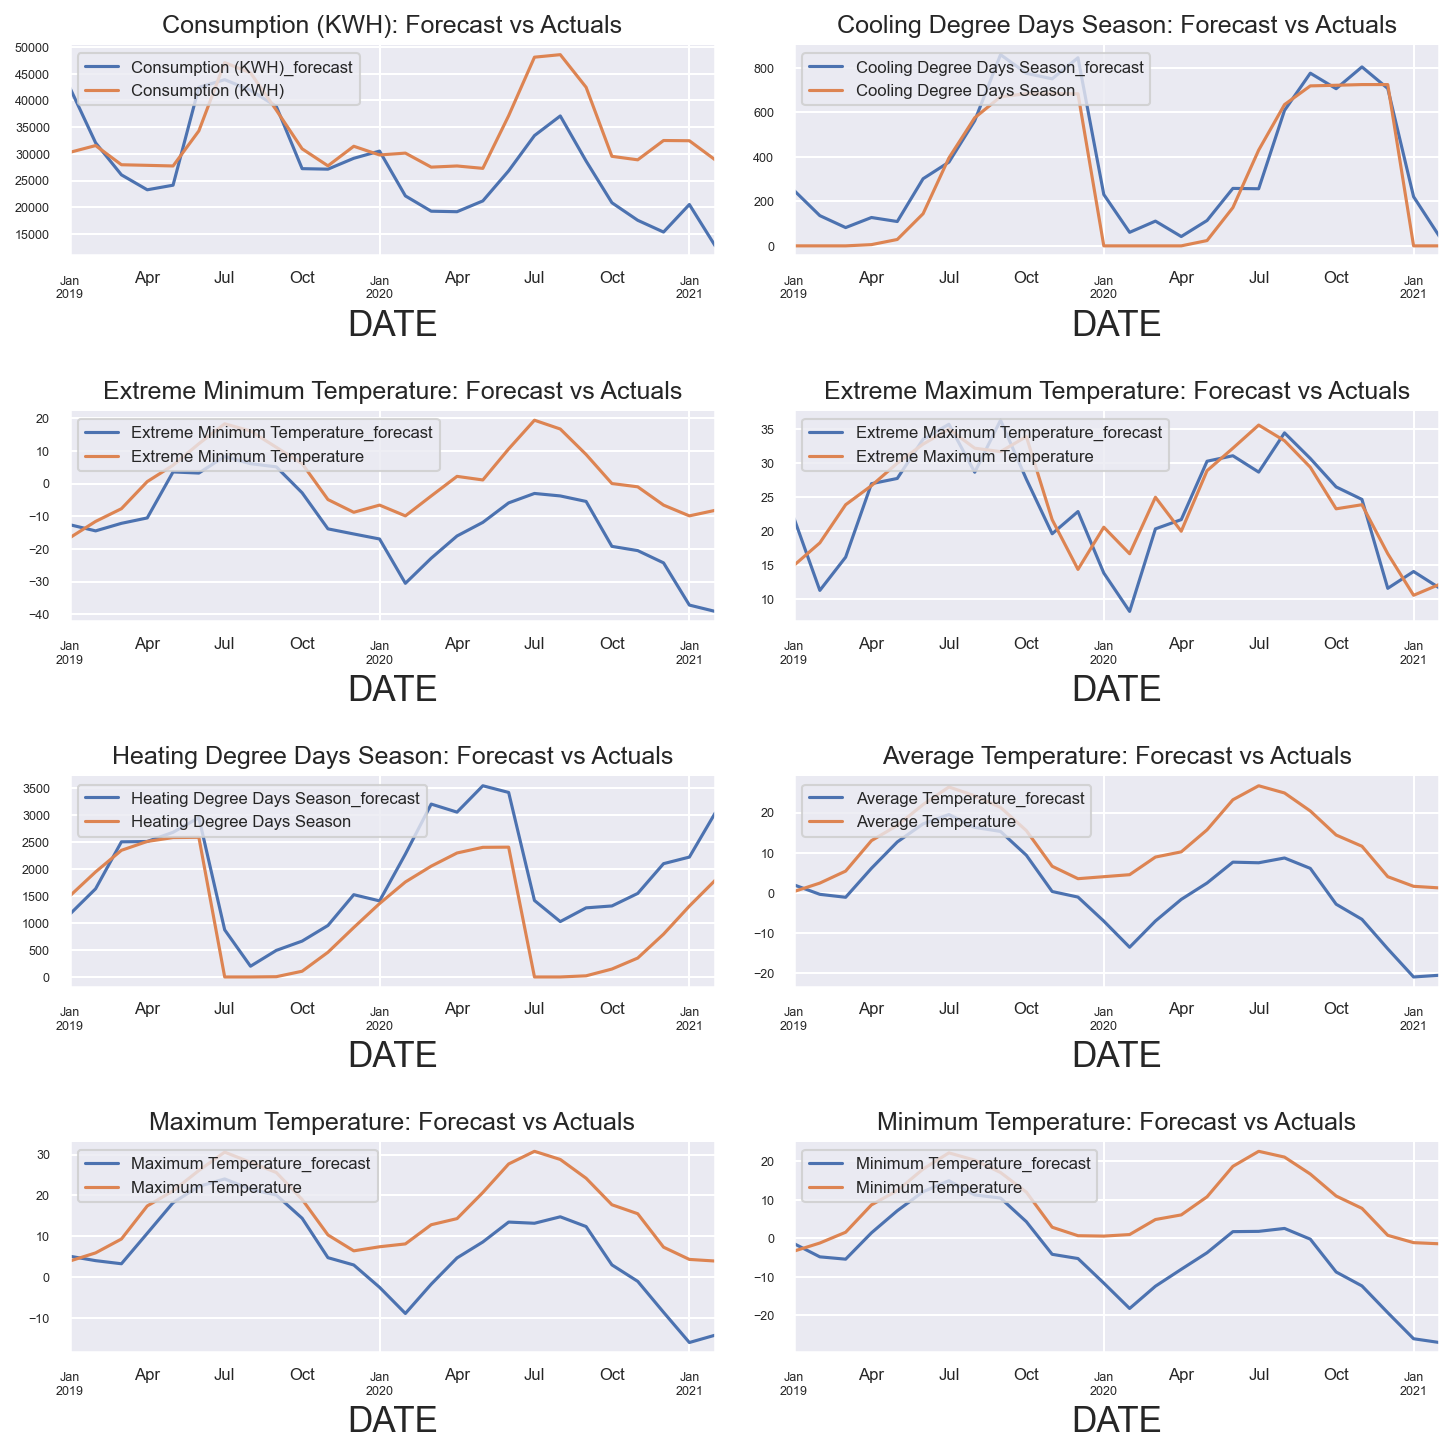

In [91]:
# plotting forecast vs actuals
fig, axes = plt.subplots(nrows=int(len(manhattan_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(manhattan_data.columns, axes.flatten())):
    df_var_results_test[col+'_forecast'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    test[col][-test_nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [92]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_test = forecast_accuracy(df_var_results_test['Consumption (KWH)_forecast'].values, test['Consumption (KWH)'])
for k, v in accuracy_test.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.2227
me     :  -5659.8349
mae    :  7368.0266
mpe    :  -0.1691
rmse   :  8934.2114
corr   :  0.6334
minmax :  0.2165


<ipython-input-86-968d63a3b996>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-86-968d63a3b996>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [93]:
performance.append('VAR test (train1) - RMSE: 8,934. MAPE: 22%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%']

>The VAR forecast for the electricity consumption in the test set is off by around 8,934 KWH. About 22% of forcasted data points are off on average, which is worse than the validation set forecast. This might be due to the gap between the validation set and the test set. It could be the size of training data or just the algorithm not performing well. Let's see how model performs with more training data.

### Using Train Set Version 2

In [94]:
# instantiating VAR model
var_model2 = VAR(data_differenced)

# finding optimal order(p) of the VAR model
var_model2.select_order().summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.table.SimpleTable'>

>The optimal lag is observed at a lag order of 6 this time.

In [95]:
var_result2 = var_model2.fit(6)
var_result2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Sep, 2021
Time:                     16:17:36
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    38.4077
Nobs:                     64.0000    HQIC:                   30.3938
Log likelihood:          -1140.40    FPE:                4.29834e+12
AIC:                      25.1845    Det(Omega_mle):     4.55106e+10
--------------------------------------------------------------------
Results for equation Consumption (KWH)
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                -42.006687       350.112756           -0.120           0.904
L1.Consumption (KWH)                  -1.095399         0.164550           -6.

In [96]:
# getting the lag order
lag_order = var_result2.k_ar
print(lag_order)  

# input data for forecasting
forecast_input2 = data_differenced.values[-lag_order:]
forecast_input2

6


array([[ 9.67006654e+03,  7.28000000e+01,  2.20000000e+00,
        -1.10000000e+00, -2.39000000e+03, -3.40000000e+00,
        -3.80000000e+00, -3.00000000e+00],
       [-2.56901811e+04, -4.65000000e+01, -7.20000000e+00,
        -1.10000000e+00,  2.37670000e+03, -4.20000000e+00,
        -3.90000000e+00, -4.40000000e+00],
       [ 4.11841633e+03, -5.35000000e+01, -2.30000000e+00,
         6.00000000e-01,  1.02000000e+01, -5.00000000e-01,
        -3.00000000e-01, -6.00000000e-01],
       [ 5.17677928e+03, -6.06000000e+01, -3.20000000e+00,
        -4.00000000e+00,  4.67000000e+01, -1.50000000e+00,
        -1.80000000e+00, -1.40000000e+00],
       [-4.99621179e+03, -4.21000000e+01, -3.30000000e+00,
        -5.00000000e-01,  2.48800000e+02, -6.30000000e+00,
        -5.90000000e+00, -6.40000000e+00],
       [ 7.19278852e+03,  0.00000000e+00,  1.50000000e+00,
        -2.20000000e+00,  2.09000000e+02,  3.40000000e+00,
         1.70000000e+00,  4.90000000e+00]])

In [97]:
# forecasting
var_pred_test2 = var_result2.forecast(y=forecast_input2, steps=test_nobs)
df_forecast_test2 = pd.DataFrame(var_pred_test2, index=manhattan_data.index[-test_nobs:], columns=manhattan_data.columns + '_2d')
df_forecast_test2

Consumption (KWH)_2d  Cooling Degree Days Season_2d  \
DATE                                                              
2019-01-01          -3152.462206                    -650.985489   
2019-02-01           -119.894631                     636.688256   
2019-03-01          -8276.347477                     -61.282325   
2019-04-01           8599.230663                    -107.645418   
2019-05-01           7895.643413                     114.789156   
2019-06-01          -1298.735356                     195.853025   
2019-07-01           7641.938923                     137.263925   
2019-08-01         -20272.253461                     -38.306627   
2019-09-01           7692.965696                     -42.440845   
2019-10-01         -10161.969501                    -121.062804   
2019-11-01           4913.907189                    -205.873926   
2019-12-01           3152.337336                      79.583557   
2020-01-01           3728.597336                    -655.405796   
2020-02-01          -6647.067138                     663.966523   
2020-03-01           -973.670974                     -22.202679   
2020-04-01          10717.923690                      27.974000   
2020-05-01          -4514.581437                      85.580928   
2020-06-01           3409.835648                      75.876757   
2020-07-01           2172.808955                      76.337809   
2020-08-01          -6672.349992                     -58.552944   
2020-09-01           -357.855909                     -10.861709   
2020-10-01          -8479.870477                     -76.367018   
2020-11-01           7470.488866                    -122.969933   
2020-12-01           1218.986311                     168.636670   
2021-01-01          -1730.819551                    -779.694225   
2021-02-01          -5359.481360                     571.044696   

            Extreme Minimum Temperature_2d  Extreme Maximum Temperature_2d  \
DATE                                                                         
2019-01-01                       -2.190006                        7.531131   
2019-02-01                       10.886995                       -6.479535   
2019-03-01                        0.878892                        4.747632   
2019-04-01                        6.063013                       15.359372   
2019-05-01                        5.617920                       -2.277892   
2019-06-01                      -14.487188                      -13.099279   
2019-07-01                        4.592389                        7.427020   
2019-08-01                       -5.424020                       -6.435834   
2019-09-01                       -3.643884                       -4.601280   
2019-10-01                        0.181013                       -3.488802   
2019-11-01                       -5.585922                        3.856650   
2019-12-01                       11.794424                        6.884141   
2020-01-01                      -10.495337                       -5.214454   
2020-02-01                        4.612477                        0.188397   
2020-03-01                        5.622223                        7.861916   
2020-04-01                        6.138127                        4.024658   
2020-05-01                        2.892708                       -4.980077   
2020-06-01                       -8.644777                       -5.649127   
2020-07-01                        6.743795                       10.038980   
2020-08-01                       -5.135061                       -7.376238   
2020-09-01                       -9.070154                       -1.787938   
2020-10-01                       -5.747291                       -4.000100   
2020-11-01                        5.390011                        0.792999   
2020-12-01                        1.685619                       -1.649115   
2021-01-01                       -5.468345                       -0.332620   
2021-02-01                   

In [98]:
df_var_results_test2 = invert_transformation(data, df_forecast_test2, second_diff=True)        
df_var_results_test2

Consumption (KWH)_2d  Cooling Degree Days Season_2d  \
DATE                                                              
2019-01-01          -3152.462206                    -650.985489   
2019-02-01           -119.894631                     636.688256   
2019-03-01          -8276.347477                     -61.282325   
2019-04-01           8599.230663                    -107.645418   
2019-05-01           7895.643413                     114.789156   
2019-06-01          -1298.735356                     195.853025   
2019-07-01           7641.938923                     137.263925   
2019-08-01         -20272.253461                     -38.306627   
2019-09-01           7692.965696                     -42.440845   
2019-10-01         -10161.969501                    -121.062804   
2019-11-01           4913.907189                    -205.873926   
2019-12-01           3152.337336                      79.583557   
2020-01-01           3728.597336                    -655.405796   
2020-02-01          -6647.067138                     663.966523   
2020-03-01           -973.670974                     -22.202679   
2020-04-01          10717.923690                      27.974000   
2020-05-01          -4514.581437                      85.580928   
2020-06-01           3409.835648                      75.876757   
2020-07-01           2172.808955                      76.337809   
2020-08-01          -6672.349992                     -58.552944   
2020-09-01           -357.855909                     -10.861709   
2020-10-01          -8479.870477                     -76.367018   
2020-11-01           7470.488866                    -122.969933   
2020-12-01           1218.986311                     168.636670   
2021-01-01          -1730.819551                    -779.694225   
2021-02-01          -5359.481360                     571.044696   

            Extreme Minimum Temperature_2d  Extreme Maximum Temperature_2d  \
DATE                                                                         
2019-01-01                       -2.190006                        7.531131   
2019-02-01                       10.886995                       -6.479535   
2019-03-01                        0.878892                        4.747632   
2019-04-01                        6.063013                       15.359372   
2019-05-01                        5.617920                       -2.277892   
2019-06-01                      -14.487188                      -13.099279   
2019-07-01                        4.592389                        7.427020   
2019-08-01                       -5.424020                       -6.435834   
2019-09-01                       -3.643884                       -4.601280   
2019-10-01                        0.181013                       -3.488802   
2019-11-01                       -5.585922                        3.856650   
2019-12-01                       11.794424                        6.884141   
2020-01-01                      -10.495337                       -5.214454   
2020-02-01                        4.612477                        0.188397   
2020-03-01                        5.622223                        7.861916   
2020-04-01                        6.138127                        4.024658   
2020-05-01                        2.892708                       -4.980077   
2020-06-01                       -8.644777                       -5.649127   
2020-07-01                        6.743795                       10.038980   
2020-08-01                       -5.135061                       -7.376238   
2020-09-01                       -9.070154                       -1.787938   
2020-10-01                       -5.747291                       -4.000100   
2020-11-01                        5.390011                        0.792999   
2020-12-01                        1.685619                       -1.649115   
2021-01-01                       -5.468345                       -0.332620   
2021-02-01                   

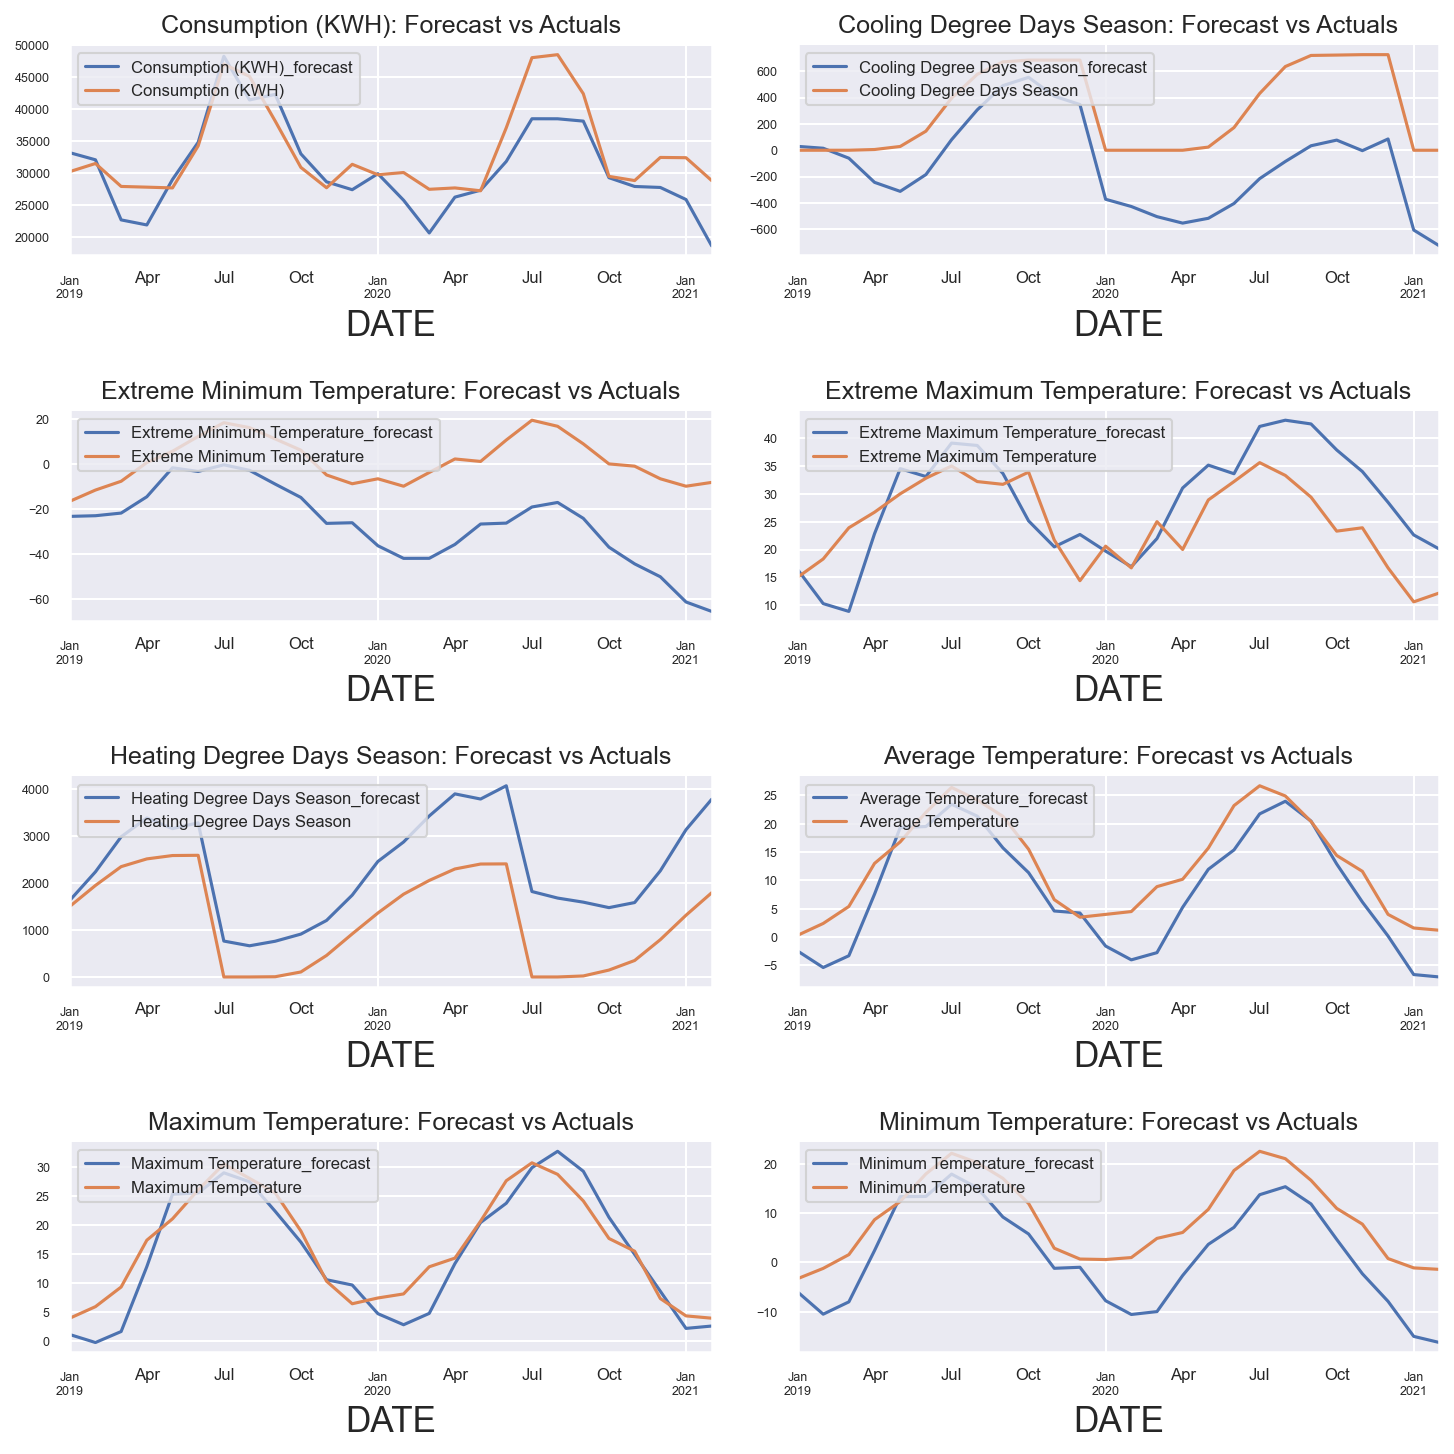

In [99]:
# plotting forecast vs actuals
fig, axes = plt.subplots(nrows=int(len(manhattan_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(manhattan_data.columns, axes.flatten())):
    df_var_results_test2[col+'_forecast'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    test[col][-test_nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [100]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_test2 = forecast_accuracy(df_var_results_test2['Consumption (KWH)_forecast'].values, test['Consumption (KWH)'])
for k, v in accuracy_test2.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.11
me     :  -2650.4407
mae    :  3736.3097
mpe    :  -0.0773
rmse   :  4809.3654
corr   :  0.8322
minmax :  0.1089


<ipython-input-86-968d63a3b996>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-86-968d63a3b996>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [101]:
performance.append('VAR test (train2) - RMSE: 4,809. MAPE: 11%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%']

>With the 2nd version of the train set, the VAR forecast for the electricity consumption in the test set is off by around 4,809 KWH. About 11% of forcasted data points are off on average, which is better than the previous results. 

## VARMAX Model

The Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX) is a multivariate version of the ARMAX model. It can be used when variables are not only contemporaneously correlated to each other, but they are also correlated to each other's past values.

### Using Train Set Version 1

In [102]:
varmax_model = VARMAX(train, enforce_stationarity=True, order=(5,0))

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [103]:
varmax_result = varmax_model.fit(disp=False)
varmax_result.summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                                                                                            Statespace Model Results                                                                                                                            
================================================================================================================================================================================================================================================================================
Dep. Variable:     ['Consumption (KWH)', 'Cooling Degree Days Season', 'Extreme Minimum Temperature', 'Extreme Maximum Temperature', 'Heating Degree Days Season', 'Average Temperature', 'Maximum Temperature', 'Minimum Temperature']   No. Observations:                   60
Model:                                                                                                                                                                                                                           VAR(5)   Log Likelihood               -1811.344
                                                                                                                                                                                                                            + intercept   AIC                           4350.689
Date:                                                                                                                                                                                                                  Wed, 08 Sep 2021   BIC                           5113.030
Time:                                                                                                                                                                                                                          16:20:05   HQIC                          4648.882
Sample:                                                                                                                                                                                                                      01-01-2012                                         
                                                                                                                                                                                                                           - 12-01-2016                                         
Covariance Type:                                                                                                                                                                                                                    opg                                         
===============================================================================================================================================
Ljung-Box (L1) (Q):     5.77, 1.99, 0.31, 4.70, 2.40, 11.76, 0.09, 8.11   Jarque-Bera (JB):   20.82, 2.03, 4.38, 3.29, 12.01, 1.19, 12.70, 1.07
Prob(Q):                 0.02, 0.16, 0.58, 0.03, 0.12, 0.00, 0.76, 0.00   Prob(JB):              0.00, 0.36, 0.11, 0.19, 0.00, 0.55, 0.00, 0.59
Heteroskedasticity (H):  0.36, 1.56, 1.13, 0.29, 1.54, 0.79, 0.89, 0.81   Skew:               0.97, 0.30, -0.62, -0.54, 0.77, -0.22, 0.42, 0.01
Prob(H) (two-sided):     0.03, 0.32, 0.79, 0.01, 0.34, 0.60, 0.80, 0.64   Kurtosis:              5.14, 3.67, 3.49, 3.37, 4.55, 2.47, 5.09, 2.35
                              Results for equation Consumption (KWH)                              
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                        3.54e+04   9.14e-09   3.87e+12      0.000    3.54e+04    3.54e+04
L1.Cons

In [104]:
varmax_pred = varmax_result.get_prediction(start='2017-01-01', end='2017-12-01')
predictions = varmax_pred.predicted_mean

In [105]:
predictions.columns=data.columns + '_pred'
predictions

Consumption (KWH)_pred  Cooling Degree Days Season_pred  \
2017-01-01            31610.391365                       243.422727   
2017-02-01            31400.336488                        25.998221   
2017-03-01            27942.227863                         2.166888   
2017-04-01            26931.722691                       -15.153118   
2017-05-01            29662.317763                        66.671936   
2017-06-01            34938.760082                       263.537143   
2017-07-01            41377.689830                       406.382754   
2017-08-01            43100.658332                       532.273002   
2017-09-01            42118.284736                       618.395551   
2017-10-01            37666.299864                       608.217347   
2017-11-01            33972.577278                       535.764720   
2017-12-01            32446.523547                       426.257341   

            Extreme Minimum Temperature_pred  \
2017-01-01                         -8.956014   
2017-02-01                        -11.532131   
2017-03-01                         -7.221657   
2017-04-01                         -1.954747   
2017-05-01                          5.257019   
2017-06-01                          9.671654   
2017-07-01                         13.263897   
2017-08-01                         12.335206   
2017-09-01                          9.170608   
2017-10-01                          4.254048   
2017-11-01                         -0.455721   
2017-12-01                         -4.134122   

            Extreme Maximum Temperature_pred  Heating Degree Days Season_pred  \
2017-01-01                         16.447803                      1255.328381   
2017-02-01                         14.487546                      1672.553876   
2017-03-01                         19.668686                      2187.986765   
2017-04-01                         25.177416                      2326.733035   
2017-05-01                         30.476075                      2180.312409   
2017-06-01                         32.421852                      1801.824856   
2017-07-01                         33.655831                      1000.239774   
2017-08-01                         32.241433                       427.136635   
2017-09-01                         30.153522                       214.462424   
2017-10-01                         27.028547                       353.006790   
2017-11-01                         23.641779                       638.354903   
2017-12-01                         20.665490                       983.427259   

            Average Temperature_pred  Maximum Temperature_pred  \
2017-01-01                  3.633258                  6.860564   
2017-02-01                  2.758527                  6.245281   
2017-03-01                  6.517196                 10.643564   
2017-04-01                 11.154224                 15.854977   
2017-05-01                 16.677197                 21.648576   
2017-06-01                 19.872908                 24.662819   
2017-07-01                 22.255064                 26.699603   
2017-08-01                 21.198767                 25.355525   
2017-09-01                 18.452371                 22.385557   
2017-10-01                 14.490172                 18.213762   
2017-11-01                 10.582140                 14.129295   
2017-12-01                  7.448104                 10.829973   

            Minimum Temperature_pred  
2017-01-01                  0.278056  
2017-02-01                 -0.843131  
2017-03-01                  2.530527  
2017-04-01                  6.732485  
2017-05-01                 11.985729  
2017-06-01                 15.274870  
2017-07-01                 17.762889  
2017-08-01                 16.899988  
2017-09-01                 14.402805  
2017-10-01                 10.721853  
2017-11-01                  7.022106  
2017-12-01                  4.023361

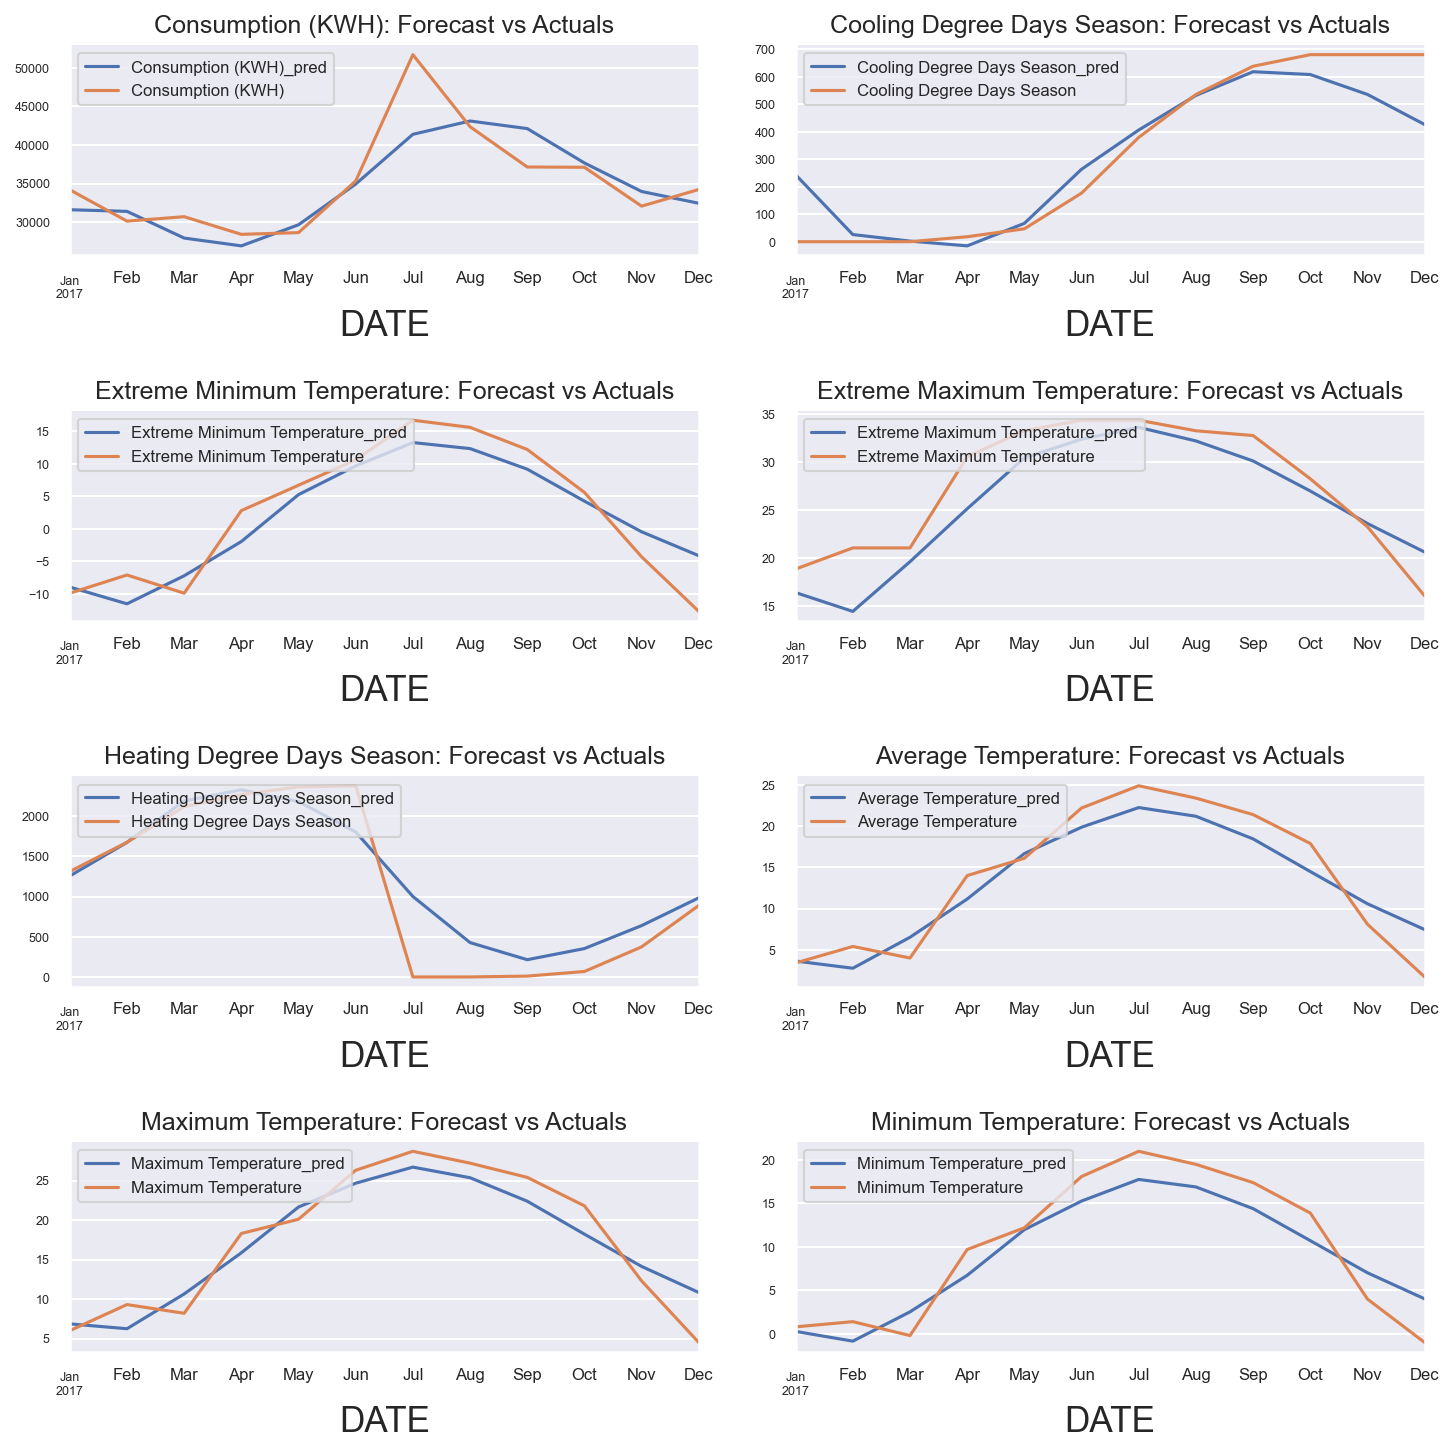

In [106]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    predictions[col+'_pred'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    val[col][-nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [107]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_prod = forecast_accuracy(predictions['Consumption (KWH)_pred'].values, val['Consumption (KWH)'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.0653
me     :  -740.8312
mae    :  2482.5054
mpe    :  -0.0148
rmse   :  3629.9374
corr   :  0.8262
minmax :  0.0635


<ipython-input-86-968d63a3b996>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-86-968d63a3b996>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [108]:
performance.append('VARMAX val (train1) - RMSE: 3,630. MAPE: 7%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
 'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%']

>The VARMAX forecast for the electricity consumption is off by around 3,630 KWH. About 7% of forcasted data points are off on average, which is better than the VAR forecasts.

#### Predicting Test set

In [109]:
varmax_pred_test = varmax_result.get_prediction(start='2019-01-01', end='2021-02-01')
predictions_test = varmax_pred_test.predicted_mean

In [110]:
predictions_test.columns = manhattan_data.columns + '_pred'
predictions_test

Consumption (KWH)_pred  Cooling Degree Days Season_pred  \
2019-01-01            32824.304980                       292.231862   
2019-02-01            32898.364245                       234.809604   
2019-03-01            33338.964828                       212.450565   
2019-04-01            34047.801800                       228.739302   
2019-05-01            34993.943649                       275.178494   
2019-06-01            36032.586472                       335.811213   
2019-07-01            36865.213503                       392.940113   
2019-08-01            37159.162183                       431.887059   
2019-09-01            36775.587046                       444.435785   
2019-10-01            35877.839378                       429.718849   
2019-11-01            34835.072929                       393.781248   
2019-12-01            34020.675367                       347.641459   
2020-01-01            33639.513675                       304.241704   
2020-02-01            33695.431278                       275.017187   
2020-03-01            34075.694577                       266.934362   
2020-04-01            34643.504818                       280.633469   
2020-05-01            35272.088393                       310.543969   
2020-06-01            35832.490851                       347.035816   
2020-07-01            36189.791153                       379.607624   
2020-08-01            36238.440401                       399.901813   
2020-09-01            35958.311502                       403.688904   
2020-10-01            35442.815464                       391.476886   
2020-11-01            34867.609337                       367.876218   
2020-12-01            34416.148466                       340.059630   
2021-01-01            34207.575339                       315.734144   
2021-02-01            34265.621593                       301.111239   

            Extreme Minimum Temperature_pred  \
2019-01-01                         -2.542078   
2019-02-01                         -1.883635   
2019-03-01                         -0.156481   
2019-04-01                          2.127957   
2019-05-01                          4.306040   
2019-06-01                          5.781541   
2019-07-01                          6.209773   
2019-08-01                          5.557925   
2019-09-01                          4.099749   
2019-10-01                          2.307868   
2019-11-01                          0.693808   
2019-12-01                         -0.331228   
2020-01-01                         -0.549996   
2020-02-01                          0.022395   
2020-03-01                          1.168658   
2020-04-01                          2.541699   
2020-05-01                          3.758355   
2020-06-01                          4.502903   
2020-07-01                          4.611009   
2020-08-01                          4.104892   
2020-09-01                          3.173297   
2020-10-01                          2.105180   
2020-11-01                          1.200211   
2020-12-01                          0.686115   
2021-01-01                          0.665190   
2021-02-01                          1.099649   

            Extreme Maximum Temperature_pred  Heating Degree Days Season_pred  \
2019-01-01                         22.136546                      1322.166395   
2019-02-01                         22.743888                      1491.699337   
2019-03-01                         24.171642                      1579.244009   
2019-04-01                         25.957116                      1568.638148   
2019-05-01                         27.531305                      1460.845480   
2019-06-01                         28.454961                      1283.200645   
2019-07-01                         28.553580                      1087.199736   
2019-08-01                         27.906806                       933.103929   
2019-09-01                         26.775938                       8

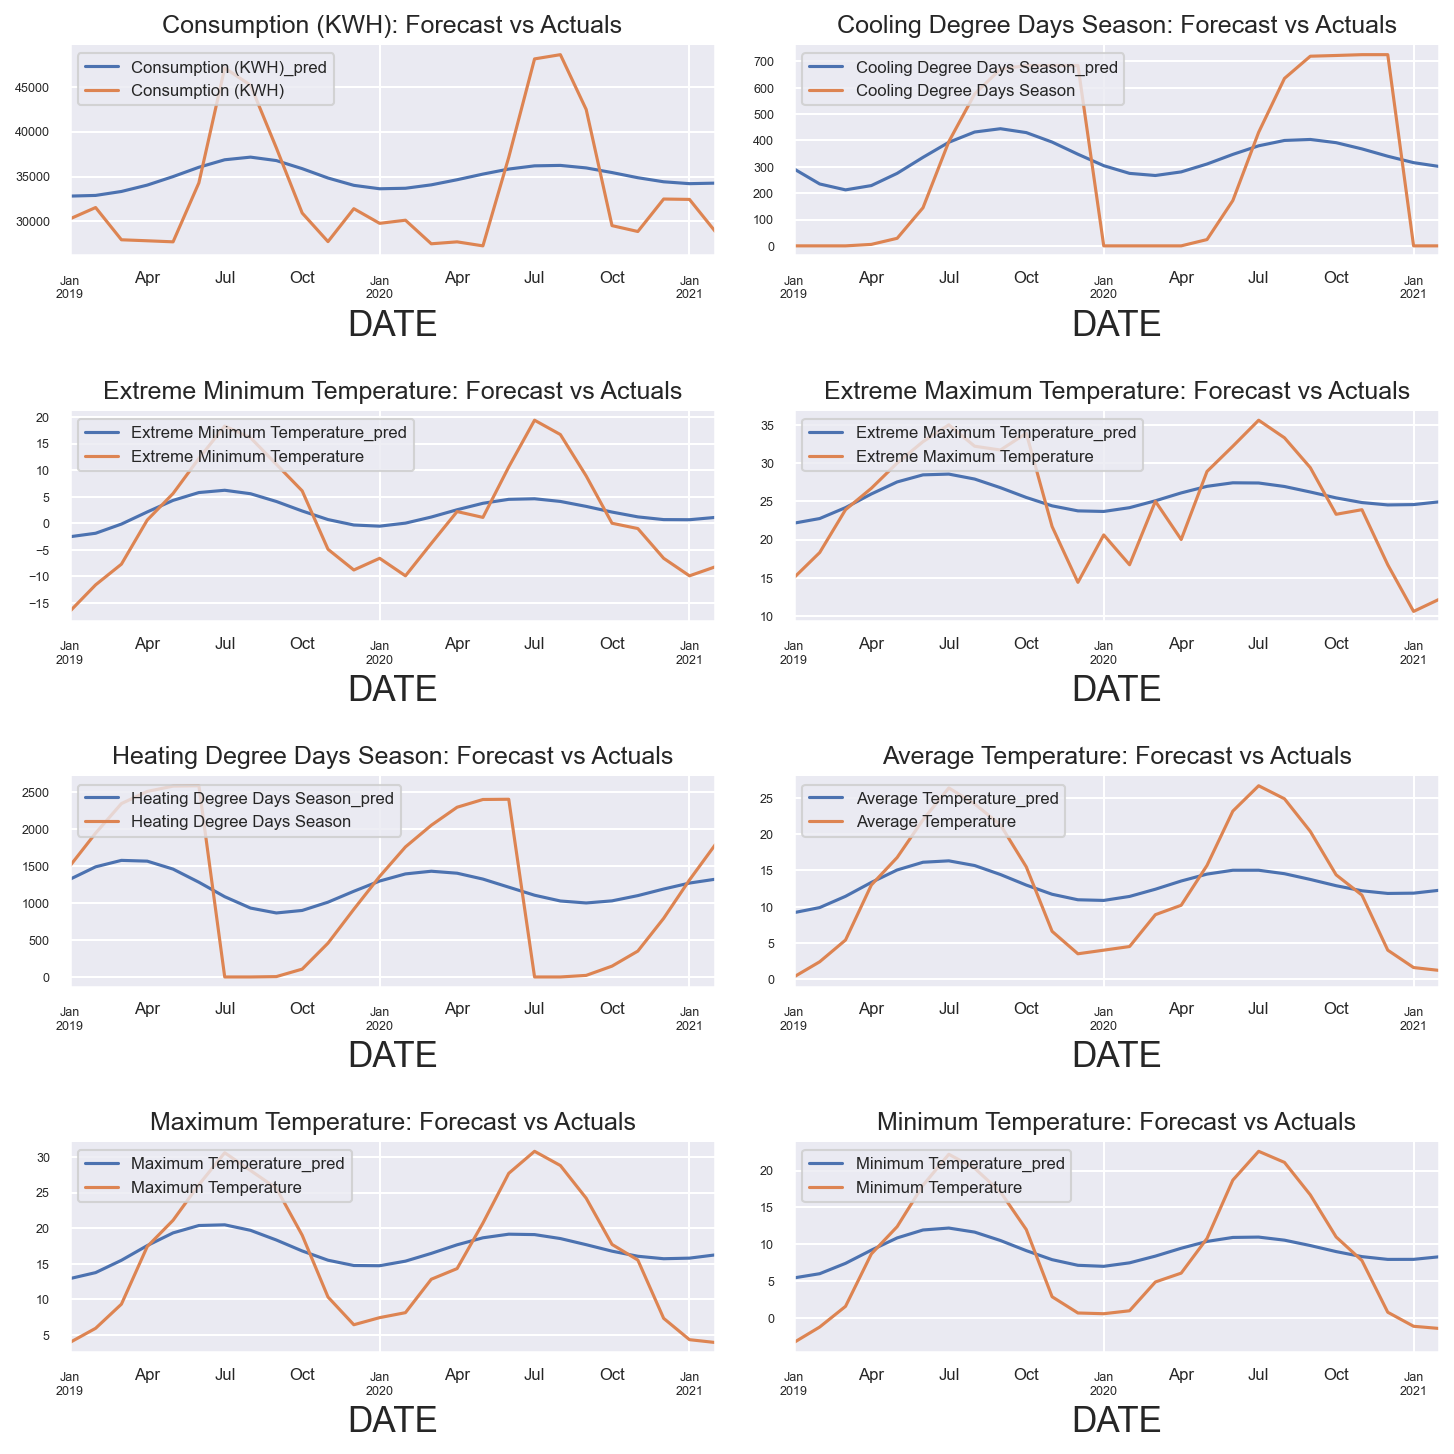

In [111]:
fig, axes = plt.subplots(nrows=int(len(manhattan_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(manhattan_data.columns, axes.flatten())):
    predictions_test[col+'_pred'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    test[col][-test_nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [112]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_test = forecast_accuracy(predictions_test['Consumption (KWH)_pred'].values, test['Consumption (KWH)'])
for k, v in accuracy_test.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.1617
me     :  1431.1189
mae    :  5403.3411
mpe    :  0.0755
rmse   :  6227.0907
corr   :  0.7109
minmax :  0.1421


<ipython-input-86-968d63a3b996>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-86-968d63a3b996>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [113]:
performance.append('VARMAX test (train1) - RMSE: 6,227. MAPE: 16%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
 'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%',
 'VARMAX test (train1) - RMSE: 6,227. MAPE: 16%']

>The VARMAX forecast for the electricity consumption in the test set is off by around 6,227 KWH. About 16% of forcasted data points are off on average, which is worse than the validation set forecast. 

### Using Train Set Version 2

In [114]:
varmax_model2 = VARMAX(data, enforce_stationarity=True, order=(6,0))

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [115]:
varmax_result2 = varmax_model2.fit(disp=False)
varmax_result2.summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                                                                                            Statespace Model Results                                                                                                                            
================================================================================================================================================================================================================================================================================
Dep. Variable:     ['Consumption (KWH)', 'Cooling Degree Days Season', 'Extreme Minimum Temperature', 'Extreme Maximum Temperature', 'Heating Degree Days Season', 'Average Temperature', 'Maximum Temperature', 'Minimum Temperature']   No. Observations:                   72
Model:                                                                                                                                                                                                                           VAR(6)   Log Likelihood               -2301.276
                                                                                                                                                                                                                            + intercept   AIC                           5458.551
Date:                                                                                                                                                                                                                  Wed, 08 Sep 2021   BIC                           6432.964
Time:                                                                                                                                                                                                                          16:23:45   HQIC                          5846.468
Sample:                                                                                                                                                                                                                      01-01-2012                                         
                                                                                                                                                                                                                           - 12-01-2017                                         
Covariance Type:                                                                                                                                                                                                                    opg                                         
=================================================================================================================================================
Ljung-Box (L1) (Q):     7.63, 17.52, 5.49, 9.30, 0.10, 2.27, 0.48, 8.62   Jarque-Bera (JB):      27.03, 1.72, 2.83, 15.97, 0.03, 0.88, 6.80, 6.51
Prob(Q):                 0.01, 0.00, 0.02, 0.00, 0.76, 0.13, 0.49, 0.00   Prob(JB):                0.00, 0.42, 0.24, 0.00, 0.98, 0.64, 0.03, 0.04
Heteroskedasticity (H):  0.55, 0.77, 0.97, 0.38, 0.66, 1.17, 2.33, 1.66   Skew:               1.28, -0.33, -0.48, -0.88, -0.04, 0.15, 0.20, -0.66
Prob(H) (two-sided):     0.15, 0.52, 0.93, 0.02, 0.32, 0.71, 0.04, 0.22   Kurtosis:                4.57, 2.63, 3.19, 4.50, 3.06, 3.45, 4.45, 3.66
                              Results for equation Consumption (KWH)                              
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                       3.536e+04   1.65e-08   2.15e+12      0.000    3.54e+04    3.54e+

In [116]:
varmax_pred_test2 = varmax_result2.get_prediction(start='2019-01-01', end='2021-02-01')
predictions_test2 = varmax_pred_test2.predicted_mean

In [117]:
predictions_test2.columns = manhattan_data.columns + '_pred'
predictions_test2

Consumption (KWH)_pred  Cooling Degree Days Season_pred  \
2019-01-01            33253.827951                       299.214149   
2019-02-01            30804.140144                       199.212198   
2019-03-01            30765.598867                       101.921005   
2019-04-01            31954.948940                        98.250111   
2019-05-01            33836.040909                       143.189096   
2019-06-01            36397.596596                       212.440241   
2019-07-01            38290.166805                       299.092759   
2019-08-01            38056.918246                       439.492573   
2019-09-01            38142.669954                       534.639767   
2019-10-01            36569.007361                       559.457587   
2019-11-01            35494.093204                       542.165198   
2019-12-01            34870.339358                       479.397527   
2020-01-01            33664.460928                       362.445352   
2020-02-01            32151.619781                       278.954864   
2020-03-01            31764.449852                       192.063274   
2020-04-01            32339.893880                       163.042271   
2020-05-01            33818.764047                       176.932693   
2020-06-01            35608.445461                       218.685428   
2020-07-01            36765.775010                       283.661686   
2020-08-01            37038.468993                       378.986713   
2020-09-01            37270.514694                       457.160719   
2020-10-01            36642.290947                       498.192250   
2020-11-01            35988.562798                       498.920035   
2020-12-01            35215.818893                       458.760888   
2021-01-01            34143.752150                       389.527905   
2021-02-01            33096.417777                       324.798793   

            Extreme Minimum Temperature_pred  \
2019-01-01                         -4.274194   
2019-02-01                         -4.864156   
2019-03-01                         -3.673968   
2019-04-01                         -0.683436   
2019-05-01                          3.191158   
2019-06-01                          6.257133   
2019-07-01                          7.999450   
2019-08-01                          8.758773   
2019-09-01                          7.978622   
2019-10-01                          5.954258   
2019-11-01                          2.999584   
2019-12-01                          0.126753   
2020-01-01                         -2.049911   
2020-02-01                         -2.894723   
2020-03-01                         -2.477259   
2020-04-01                         -0.747513   
2020-05-01                          1.831841   
2020-06-01                          4.313744   
2020-07-01                          6.115369   
2020-08-01                          7.056396   
2020-09-01                          6.894179   
2020-10-01                          5.756090   
2020-11-01                          3.784410   
2020-12-01                          1.560761   
2021-01-01                         -0.308881   
2021-02-01                         -1.296594   

            Extreme Maximum Temperature_pred  Heating Degree Days Season_pred  \
2019-01-01                         21.218265                       959.483251   
2019-02-01                         21.675655                      1489.652749   
2019-03-01                         23.052434                      1848.891340   
2019-04-01                         25.048300                      1929.216951   
2019-05-01                         27.288633                      1871.612760   
2019-06-01                         29.036429                      1636.612294   
2019-07-01                         30.000409                      1178.636371   
2019-08-01                         30.189173                       906.409444   
2019-09-01                         29.552287                       6

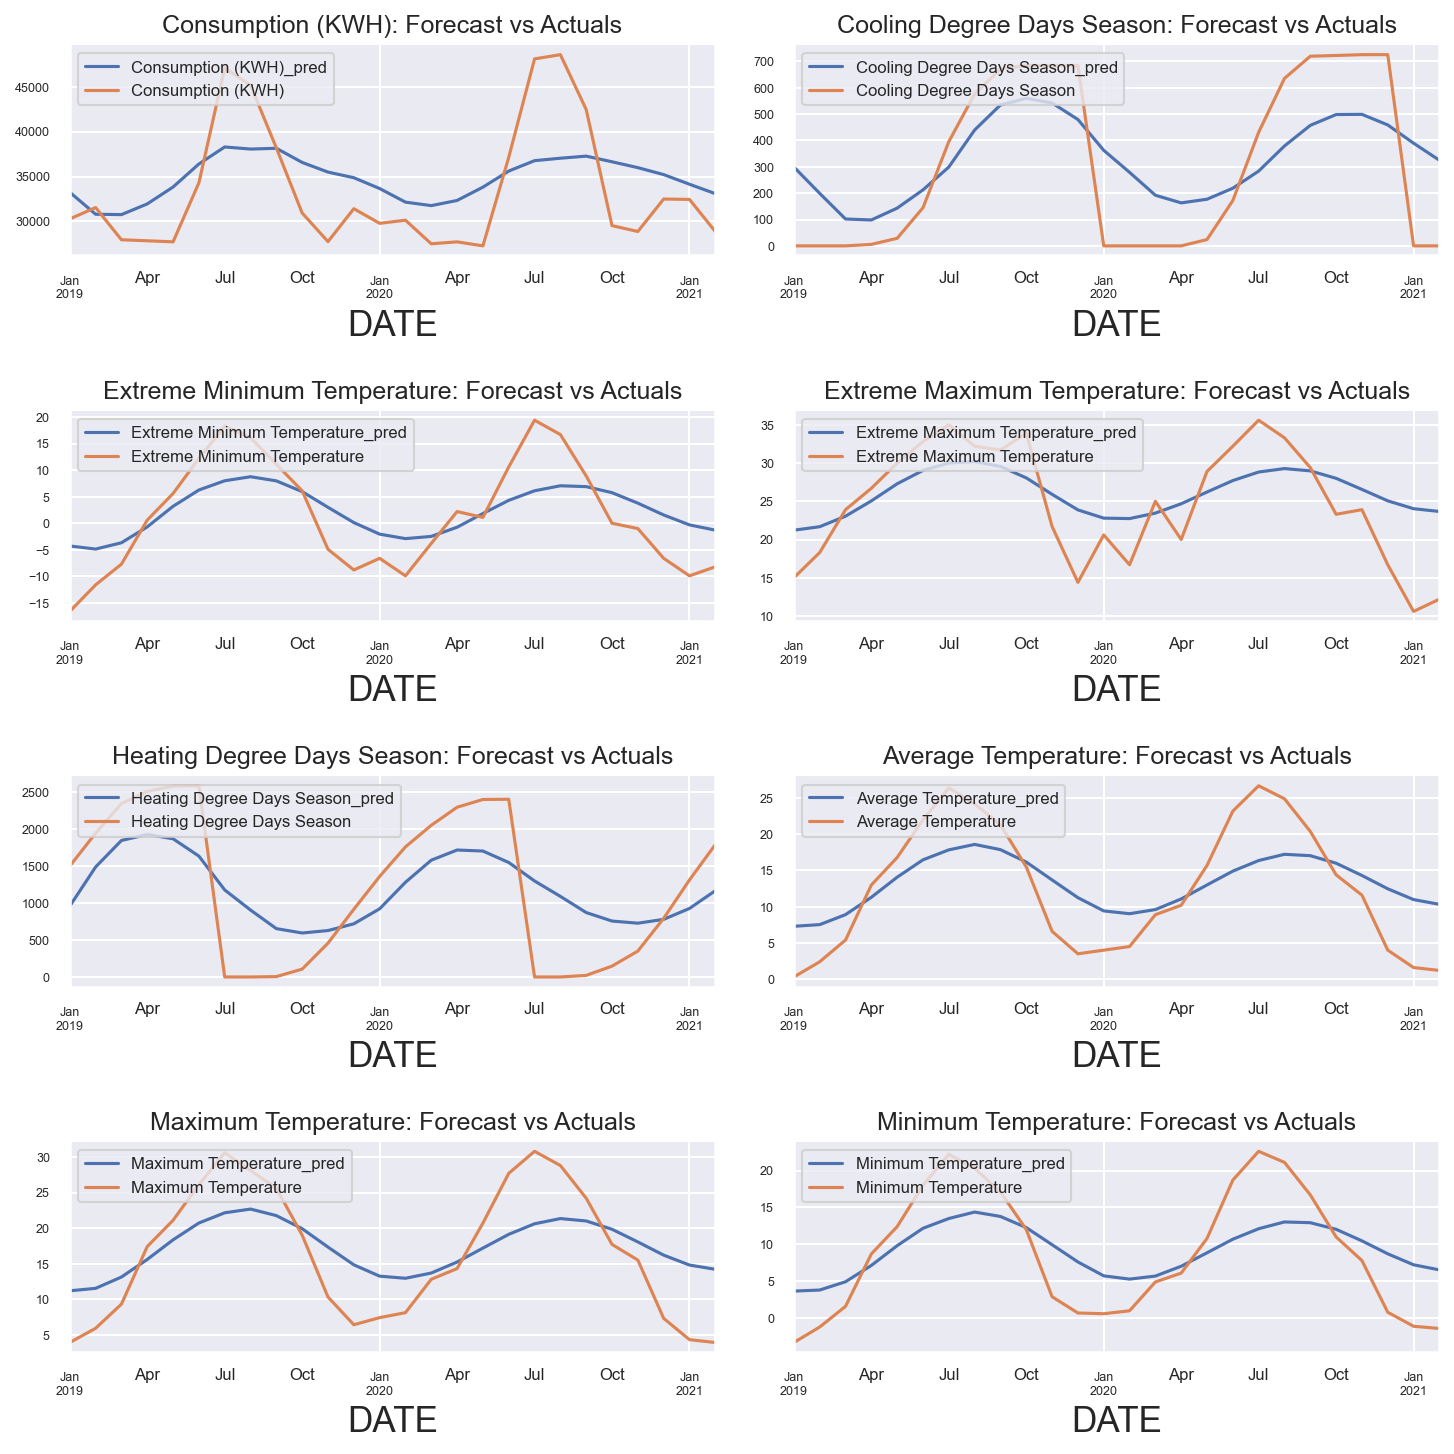

In [118]:
fig, axes = plt.subplots(nrows=int(len(manhattan_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(manhattan_data.columns, axes.flatten())):
    predictions_test2[col+'_pred'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    test[col][-test_nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [119]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_test2 = forecast_accuracy(predictions_test2['Consumption (KWH)_pred'].values, test['Consumption (KWH)'])
for k, v in accuracy_test2.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.1433
me     :  1259.1969
mae    :  4815.5492
mpe    :  0.066
rmse   :  5638.5972
corr   :  0.7081
minmax :  0.1275


<ipython-input-86-968d63a3b996>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-86-968d63a3b996>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [120]:
performance.append('VARMAX test (train2) - RMSE: 5,639. MAPE: 14%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
 'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%',
 'VARMAX test (train1) - RMSE: 6,227. MAPE: 16%',
 'VARMAX test (train2) - RMSE: 5,639. MAPE: 14%']

>With the 2nd version of the train set, the VARMAX forecast for the electricity consumption in the test set is off by around 5,639 KWH. About 14% of forcasted data points are off on average, which is better than the previous forecast in the test set but still worse than the validation forecast. So far, it looks like both the seamlessnes and the size of training dataset affect the model performance. 

## LSTM Model

Long Short-Term Memory (LSTM) recurrent neural networks can model problems with multiple input variables.

In [121]:
dataset = manhattan_data['2012-01-01':]
trainset = dataset[:'2016-12-01']
trainset2 = dataset[:'2017-12-01']
valset = data['2017-01-01':'2017-12-01']
testset = manhattan_data['2019-01-01':]

print('dataset shape: ', dataset.shape)
print('trainset shape: ', trainset.shape)
print('trainset2 shape: ', trainset2.shape)
print('valset shape: ', valset.shape)
print('testset shape: ', testset.shape)
dataset.iloc[0]

dataset shape:  (99, 8)
trainset shape:  (60, 8)
trainset2 shape:  (72, 8)
valset shape:  (12, 8)
testset shape:  (26, 8)


Consumption (KWH)              39768.191057
Cooling Degree Days Season         0.000000
Extreme Minimum Temperature      -10.600000
Extreme Maximum Temperature       16.700000
Heating Degree Days Season      1227.100000
Average Temperature                3.000000
Maximum Temperature                6.800000
Minimum Temperature               -0.900000
Name: 2012-01-01 00:00:00, dtype: float64

In [122]:
dataset = dataset.values

In [123]:
scaler = MinMaxScaler(feature_range=(0,1))

In [124]:
scaled_data = scaler.fit_transform(dataset)

In [125]:
train_data = scaled_data[:60]
train2_data = scaled_data[:72]
val_data = scaled_data[60:72]
test_data = scaled_data[-26:]
len(train_data), len(train2_data), len(val_data), len(test_data)

(60, 72, 12, 26)

In [126]:
def split_sequence(sequence, n_steps):
#convert input data into 3-D array as required for LSTM network
    
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [127]:
features = 8
n_steps = 10

In [128]:
x_train, y_train = split_sequence(train_data, n_steps)
x_train2, y_train2 = split_sequence(train2_data, n_steps)
x_test, y_test = split_sequence(test_data, n_steps)
x_val, y_val = split_sequence(val_data, n_steps)

In [129]:
x_train.shape, y_train.shape

((50, 10, 8), (50, 8))

In [130]:
early = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [131]:
test_data.shape

(26, 8)

In [132]:
y_test_re = scaler.inverse_transform(y_test)
y_test_re.shape

(16, 8)

In [133]:
model1 = Sequential()
model1.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps, features)))
model1.add(RepeatVector(n_steps))
model1.add(LSTM(128, activation='relu', return_sequences=False))
model1.add(Dense(features))

model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', ])


In [134]:
history1 = model1.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
1/1 [==============================] - 1s 797ms/step - loss: 0.3751 - mean_squared_error: 0.3751 - val_loss: 0.1825 - val_mean_squared_error: 0.1825
Epoch 2/50
1/1 [==============================] - 0s 69ms/step - loss: 0.3533 - mean_squared_error: 0.3533 - val_loss: 0.1642 - val_mean_squared_error: 0.1642
Epoch 3/50
1/1 [==============================] - 0s 86ms/step - loss: 0.3317 - mean_squared_error: 0.3317 - val_loss: 0.1455 - val_mean_squared_error: 0.1455
Epoch 4/50
1/1 [==============================] - 0s 56ms/step - loss: 0.3088 - mean_squared_error: 0.3088 - val_loss: 0.1259 - val_mean_squared_error: 0.1259
Epoch 5/50
1/1 [==============================] - 0s 92ms/step - loss: 0.2838 - mean_squared_error: 0.2838 - val_loss: 0.1045 - val_mean_squared_error: 0.1045
Epoch 6/50
1/1 [==============================] - 0s 62ms/step - loss: 0.2555 - mean_squared_error: 0.2555 - val_loss: 0.0818 - val_mean_squared_error: 0.0818
Epoch 7/50
1/1 [=============================

In [135]:
y_pred1 = model1.predict(x_test)


In [136]:
y_pred_inv1 = scaler.inverse_transform(y_pred1)


In [137]:
y_test_inv = scaler.inverse_transform(y_test)

rmse1 = np.sqrt(np.mean(((y_pred_inv1 -y_test_inv) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')


RMSE：3153.895


### "Question: Make a seperate notebook for modeling OR Add a table of content in one notebook?"

# XGB, RF,,,,